# Part 1.1: Image Processing and Dataset Creation

**Objective:** Convert the border image to binary mask and create a dataset class that returns shuffled pixel coordinates with labels.

**Key Requirements:**
1. Convert colored image (orange/purple) to 0-1 binary mask
2. Create dataset class that returns ((x,y), label) pairs
3. Coordinates normalized to [0,1], labels ∈ {0,1}
4. Data returned in shuffled order

In [47]:
%pip install numpy 
%pip install matplotlib 
%pip install seaborn 
# %pip install PIL
%pip install tqdm  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import pickle
import json
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Testing BorderImageProcessor...
Image loaded successfully: 50x50 pixels
Binary mask created:
  Total pixels: 2500
  Netherlands (1): 1986 (79.4%)
  Belgium (0): 514 (20.6%)


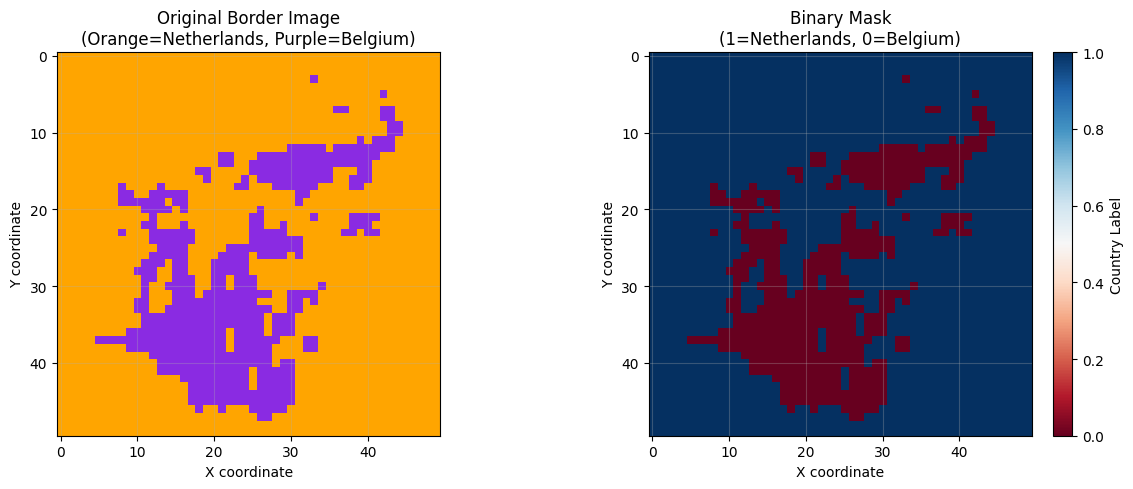

Image processing completed successfully!


In [48]:
class BorderImageProcessor:
    """
    Processes the border image and converts it to binary mask.
    
    This class handles:
    1. Loading the border image
    2. Converting colored pixels to binary labels
    3. Creating visualizations
    """
    
    def __init__(self, image_path):
        """
        Initialize the processor with image path.
        
        Args:
            image_path (str): Path to the border image
        """
        self.image_path = image_path
        self.original_image = None # Stores the RGB image as a NumPy array
        self.binary_mask = None # Will later hold the 0/1 mask
        self.height = None # Image dimensions (pixels)
        self.width = None # Image dimensions (pixels)
        
    def load_image(self):
        """Load and process the border image."""
        try:
            # Load image using PIL
            img = Image.open(self.image_path)
            # Convert to RGB if not already
            img = img.convert('RGB')
            # Convert to numpy array
            self.original_image = np.array(img)
            self.height, self.width = self.original_image.shape[:2] # Extracts its height and width.
            print(f"Image loaded successfully: {self.width}x{self.height} pixels")
            return True
        except Exception as e:
            print(f"Error loading image: {e}")
            return False
    
    def create_binary_mask(self, visualize=True):
        """
        Convert the colored image to binary mask.
        
        Orange pixels (Netherlands) -> 1
        Purple pixels (Belgium) -> 0
        
        Args:
            visualize (bool): Whether to show visualization
            
        Returns:
            numpy.ndarray: Binary mask of shape (height, width)
        """
        if self.original_image is None:
            print("Please load image first!")
            return None
            
        # Convert RGB to binary based on color dominance
        # Orange has high red and green, low blue
        # Purple has high red and blue, low green
        
        # Method: Use color distance to typical orange and purple
        # For each pixel, compute Euclidean distance in RGB space to each reference color.
        orange_color = np.array([255, 165, 0])  # Typical orange
        purple_color = np.array([128, 0, 128])  # Typical purple
        
        # Calculate distance to each color for every pixel
        orange_dist = np.sqrt(np.sum((self.original_image - orange_color) ** 2, axis=2))
        purple_dist = np.sqrt(np.sum((self.original_image - purple_color) ** 2, axis=2))
        
        # Assign label based on closer color
        # 1 for orange (Netherlands), 0 for purple (Belgium)
        # If orange distance is smaller -> pixel is closer to orange -> assign 1.
        # Otherwise -> pixel is closer to purple -> assign 0.
        
        self.binary_mask = (orange_dist < purple_dist).astype(int)
        
        # Show statistics
        total_pixels = self.height * self.width
        netherlands_pixels = np.sum(self.binary_mask)
        belgium_pixels = total_pixels - netherlands_pixels
        
        print(f"Binary mask created:")
        print(f"  Total pixels: {total_pixels}")
        print(f"  Netherlands (1): {netherlands_pixels} ({netherlands_pixels/total_pixels*100:.1f}%)")
        print(f"  Belgium (0): {belgium_pixels} ({belgium_pixels/total_pixels*100:.1f}%)")
        
        if visualize:
            self.visualize_conversion()
            
        return self.binary_mask
    
    def visualize_conversion(self):
        """Visualize the original image and binary mask side by side."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original image
        axes[0].imshow(self.original_image)
        axes[0].set_title('Original Border Image\n(Orange=Netherlands, Purple=Belgium)')
        axes[0].set_xlabel('X coordinate')
        axes[0].set_ylabel('Y coordinate')
        axes[0].grid(True, alpha=0.3)
        
        # Binary mask
        axes[1].imshow(self.binary_mask, cmap='RdBu', vmin=0, vmax=1)
        axes[1].set_title('Binary Mask\n(1=Netherlands, 0=Belgium)')
        axes[1].set_xlabel('X coordinate')
        axes[1].set_ylabel('Y coordinate')
        axes[1].grid(True, alpha=0.3)
        
        # Add colorbar for binary mask
        cbar = plt.colorbar(axes[1].imshow(self.binary_mask, cmap='RdBu', vmin=0, vmax=1), 
                           ax=axes[1], fraction=0.046, pad=0.04)
        cbar.set_label('Country Label')
        
        plt.tight_layout()
        plt.show()

# Test the image processor
print("Testing BorderImageProcessor...")
border_image_path = "Q1-20251008T082357Z-1-001/Q1/border.png"


processor = BorderImageProcessor(border_image_path)
if processor.load_image():
    binary_mask = processor.create_binary_mask()
    print("Image processing completed successfully!")
else:
    print("Failed to load image")


In [49]:
class BorderDataset:
    """
    Dataset class for the border classification problem.
    
    Returns pixel coordinates and labels in shuffled order.
    Coordinates are normalized to [0, 1] range.
    """
    
    def __init__(self, binary_mask, shuffle=True, seed=42):
        """
        Initialize the dataset.
        
        Args:
            binary_mask (numpy.ndarray): Binary mask of shape (height, width)
            shuffle (bool): Whether to shuffle the data
            seed (int): Random seed for reproducibility
        """
        self.binary_mask = binary_mask
        self.height, self.width = binary_mask.shape
        self.shuffle = shuffle
        self.seed = seed
        
        # Create all coordinate-label pairs
        self._create_dataset()
        
    def _create_dataset(self):
        """Create the complete dataset of coordinates and labels."""
        # Generate all pixel coordinates
        y_coords, x_coords = np.meshgrid(range(self.height), range(self.width), indexing='ij')
        
        # Flatten coordinates
        self.all_x = x_coords.flatten()
        self.all_y = y_coords.flatten()
        self.all_labels = self.binary_mask.flatten()
        
        # Normalize coordinates to [0, 1]
        self.normalized_x = self.all_x / (self.width - 1)
        self.normalized_y = self.all_y / (self.height - 1)
        
        # Create indices for shuffling
        self.indices = np.arange(len(self.all_x))
        
        if self.shuffle:
            np.random.seed(self.seed)
            np.random.shuffle(self.indices)
            
        self.total_samples = len(self.indices)
        
        print(f"Dataset created:")
        print(f"  Total samples: {self.total_samples}")
        print(f"  Image size: {self.width}x{self.height}")
        print(f"  Coordinates normalized to [0, 1]")
        print(f"  Shuffled: {self.shuffle}")
        
    def __len__(self):
        """Return the total number of samples."""
        return self.total_samples
    
    def __getitem__(self, idx):
        """
        Get a single sample.
        
        Args:
            idx (int): Index of the sample
            
        Returns:
            tuple: ((x, y), label) where:
                - (x, y) are normalized coordinates in [0, 1]
                - label is 0 or 1
        """
        if idx >= self.total_samples:
            raise IndexError(f"Index {idx} out of range for dataset of size {self.total_samples}")
            
        actual_idx = self.indices[idx]
        
        x = self.normalized_x[actual_idx]
        y = self.normalized_y[actual_idx]
        label = self.all_labels[actual_idx]
        
        return (x, y), label
    
    def get_batch(self, start_idx, batch_size):
        """
        Get a batch of samples.
        
        Args:
            start_idx (int): Starting index
            batch_size (int): Size of the batch
            
        Returns:
            tuple: (coordinates, labels) where:
                - coordinates: numpy array of shape (batch_size, 2)
                - labels: numpy array of shape (batch_size,)
        """
        end_idx = min(start_idx + batch_size, self.total_samples)
        actual_batch_size = end_idx - start_idx
        
        coordinates = np.zeros((actual_batch_size, 2))
        labels = np.zeros(actual_batch_size)
        
        for i in range(actual_batch_size):
            (x, y), label = self.__getitem__(start_idx + i)
            coordinates[i] = [x, y]
            labels[i] = label
            
        return coordinates, labels
    
    def get_all_data(self):
        """
        Get all data as numpy arrays.
        
        Returns:
            tuple: (coordinates, labels) where:
                - coordinates: numpy array of shape (total_samples, 2)
                - labels: numpy array of shape (total_samples,)
        """
        return self.get_batch(0, self.total_samples)

# Test the dataset class
print("\nTesting BorderDataset...")
dataset = BorderDataset(binary_mask)

# Show first few samples
print(f"\nFirst 5 samples:")
for i in range(5):
    (x, y), label = dataset[i]
    print(f"  Sample {i}: coords=({x:.3f}, {y:.3f}), label={label}")

# Test batch retrieval
print(f"\nTesting batch retrieval:")
coords_batch, labels_batch = dataset.get_batch(0, 10)
print(f"  Batch shape: coords {coords_batch.shape}, labels {labels_batch.shape}")

print("\n Part 1.1 Complete: Image Processing and Dataset Creation")


Testing BorderDataset...
Dataset created:
  Total samples: 2500
  Image size: 50x50
  Coordinates normalized to [0, 1]
  Shuffled: True

First 5 samples:
  Sample 0: coords=(0.959, 0.571), label=1
  Sample 1: coords=(0.286, 0.449), label=1
  Sample 2: coords=(0.286, 0.429), label=1
  Sample 3: coords=(0.755, 0.918), label=1
  Sample 4: coords=(0.755, 0.612), label=1

Testing batch retrieval:
  Batch shape: coords (10, 2), labels (10,)

 Part 1.1 Complete: Image Processing and Dataset Creation


# Part 1.2: Neural Network Implementation from Scratch [15 marks]

**Objective:** Build a complete MLP from scratch with all mathematical operations implemented manually.

**Key Requirements:**
1. **Activation Functions**: ReLU, Tanh, Sigmoid, Identity (separate classes)
2. **Linear Layer**: Forward/backward pass with gradient accumulation
3. **Loss Functions**: MSE and Binary Cross Entropy  
4. **Model Class**: Complete training pipeline
5. **Training Loop**: Batch processing, early stopping, progress tracking

**Success Criteria:**
- All gradients computed correctly via backpropagation
- Gradient accumulation support for flexible batch sizes
- Early stopping mechanism (Lt ≥ 0.99 · Lt-10)
- Save/load functionality with architecture verification
- Proper progress tracking and visualization

In [50]:
# ==========================================
# STEP 1: ACTIVATION FUNCTIONS
# ==========================================

class ReLU:
    """
    Rectified Linear Unit activation function.
    f(x) = max(0, x)
    f'(x) = 1 if x > 0, else 0
    """
    
    def __init__(self):
        """Initialize ReLU activation."""
        self.last_input = None
    
    def forward(self, x):
        """
        Forward pass: f(x) = max(0, x)
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Output after ReLU activation
        """
        self.last_input = x.copy()  # Store for backward pass
        return np.maximum(0, x)
    
    def backward(self, grad_output):
        """
        Backward pass: derivative of ReLU
        f'(x) = 1 if x > 0, else 0
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient with respect to input
        """
        grad_input = grad_output.copy()
        grad_input[self.last_input <= 0] = 0  # Zero gradient where input was <= 0
        return grad_input
    
class Tanh:
    """
    Hyperbolic tangent activation function.
    f(x) = tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))
    f'(x) = 1 - tanh^2(x)
    """
    
    def __init__(self):
        """Initialize Tanh activation."""
        self.last_output = None
    
    def forward(self, x):
        """
        Forward pass: f(x) = tanh(x)
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Output after Tanh activation
        """
        self.last_output = np.tanh(x)
        return self.last_output
    
    def backward(self, grad_output):
        """
        Backward pass: derivative of Tanh
        f'(x) = 1 - tanh^2(x)
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient with respect to input
        """
        return grad_output * (1 - self.last_output ** 2)

class Sigmoid:
    """
    Sigmoid activation function.
    f(x) = 1 / (1 + e^(-x))
    f'(x) = sigmoid(x) * (1 - sigmoid(x))
    """
    
    def __init__(self):
        """Initialize Sigmoid activation."""
        self.last_output = None
    
    def forward(self, x):
        """
        Forward pass: f(x) = 1 / (1 + e^(-x))
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Output after Sigmoid activation
        """
        # Clip x to prevent overflow in exp(-x)
        x_clipped = np.clip(x, -500, 500)
        self.last_output = 1 / (1 + np.exp(-x_clipped))
        return self.last_output
    
    def backward(self, grad_output):
        """
        Backward pass: derivative of Sigmoid
        f'(x) = sigmoid(x) * (1 - sigmoid(x))
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient with respect to input
        """
        return grad_output * self.last_output * (1 - self.last_output)

class Identity:
    """
    Identity activation function (no activation).
    f(x) = x
    f'(x) = 1
    """
    
    def __init__(self):
        """Initialize Identity activation."""
        pass
    
    def forward(self, x):
        """
        Forward pass: f(x) = x
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Input unchanged
        """
        return x
    
    def backward(self, grad_output):
        """
        Backward pass: derivative of Identity
        f'(x) = 1
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient unchanged
        """
        return grad_output

# Test activation functions
print("Testing Activation Functions...")
print("=" * 50)

# Test input with positive and negative values
test_input = np.array([[-2, -1, 0, 1, 2],
                       [-0.5, 0.5, -1.5, 1.5, 0]])

activations = {
    'ReLU': ReLU(),
    'Tanh': Tanh(),
    'Sigmoid': Sigmoid(),
    'Identity': Identity()
}

for name, activation in activations.items():
    print(f"\n{name} Activation:")
    output = activation.forward(test_input)
    print(f"  Input:  {test_input[0]}")
    print(f"  Output: {output[0]}")
    
    # Test backward pass with ones as gradient
    grad_output = np.ones_like(output)
    grad_input = activation.backward(grad_output)
    print(f"  Gradient: {grad_input[0]}")



Testing Activation Functions...

ReLU Activation:
  Input:  [-2. -1.  0.  1.  2.]
  Output: [0. 0. 0. 1. 2.]
  Gradient: [0. 0. 0. 1. 1.]

Tanh Activation:
  Input:  [-2. -1.  0.  1.  2.]
  Output: [-0.96402758 -0.76159416  0.          0.76159416  0.96402758]
  Gradient: [0.07065082 0.41997434 1.         0.41997434 0.07065082]

Sigmoid Activation:
  Input:  [-2. -1.  0.  1.  2.]
  Output: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
  Gradient: [0.10499359 0.19661193 0.25       0.19661193 0.10499359]

Identity Activation:
  Input:  [-2. -1.  0.  1.  2.]
  Output: [-2. -1.  0.  1.  2.]
  Gradient: [1. 1. 1. 1. 1.]


In [51]:
# ==========================================
# STEP 2: LINEAR LAYER
# ==========================================

class Linear:
    """
    Linear (fully connected) layer with weights, biases, and activation.
    
    Implements: output = activation(input @ weights + bias)
    """
    
    def __init__(self, input_size, output_size, activation=None,std=0.1):
        """
        Initialize the linear layer.
        
        Args:
            input_size (int): Number of input features
            output_size (int): Number of output features  
            activation: Activation function object (ReLU, Tanh, Sigmoid, Identity)
        """
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation if activation is not None else Identity()
        
        # Initialize weights using Xavier/Glorot initialization - Weights are initialized randomly. The formula used here is called Xavier/Glorot initialization — it keeps the variance of outputs reasonable so gradients don’t vanish or explode.
        # # This helps with gradient flow in deep networks
        limit = np.sqrt(6.0 / (input_size + output_size))
        self.weights = np.random.uniform(-limit, limit, (input_size, output_size))
        self.bias = np.zeros((1, output_size)) # Biases start at zero.
        # Gaussian initialization
        # self.weights = np.random.normal(0, std, (input_size, output_size))
        # self.bias = np.zeros((1, output_size))
        
        # Storage for forward pass (needed for backward pass)
        # These are placeholders to store values needed for backward pass.
        # During backpropagation, we need the original inputs and outputs to compute gradients.
        
        self.last_input = None # This will store the input x that was given to the layer during the forward pass.
        self.last_linear_output = None # This will store the output before activation → that is, the raw linear combination:z=XW+b 
        self.last_output = None # This will store the final output after the activation function is applied. y=activation(z) 
        
        # Gradient accumulation
        # When backpropagation runs, it will compute how much each weight and bias should be adjusted — that’s the gradient.
        # We initialize them to zero arrays of the same shape as the weights and biases so that we can accumulate gradients over multiple batches if needed. 
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_bias = np.zeros_like(self.bias)
        
        print(f"Linear layer created: {input_size} -> {output_size}, activation: {type(self.activation).__name__}")
    
    def forward(self, x):
        """
        Forward pass through the layer.
        
        Args:
            x (numpy.ndarray): Input of shape (batch_size, input_size)
            
        Returns:
            numpy.ndarray: Output of shape (batch_size, output_size)
        """
        # Store input for backward pass - We store a copy of the input so we can use it later during backpropagation. 
        self.last_input = x.copy()
        
        # Linear transformation: y = x @ W + b 
        self.last_linear_output = x @ self.weights + self.bias
        
        # Apply activation function
        self.last_output = self.activation.forward(self.last_linear_output)
        
        return self.last_output
    
    def backward(self, grad_output):
        """
        Backward pass through the layer.
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient with respect to input
        """
        # Get gradient from activation function
        grad_linear = self.activation.backward(grad_output)
        
        # Compute gradients for weights and bias
        # grad_weights = input^T @ grad_linear
        self.grad_weights += self.last_input.T @ grad_linear
        
        # grad_bias = sum(grad_linear, axis=0) (sum over batch dimension)
        self.grad_bias += np.sum(grad_linear, axis=0, keepdims=True)
        
        # Compute gradient with respect to input
        # grad_input = grad_linear @ weights^T
        grad_input = grad_linear @ self.weights.T
        
        return grad_input
    
    def zero_grad(self):
        """
        Reset accumulated gradients to zero.
        During training, every time we process a batch of data, we compute gradients for that batch.
        If we dont reset them, they will accumulate from previous batches — giving wrong results.
        """
        self.grad_weights.fill(0)
        self.grad_bias.fill(0)
    
    def update_weights(self, learning_rate):
        """
        Update weights and biases using accumulated gradients.
        
        Args:
            learning_rate (float): Learning rate for gradient descent
        """
        self.weights -= learning_rate * self.grad_weights
        self.bias -= learning_rate * self.grad_bias

# Test the Linear layer
print("\nTesting Linear Layer...")
print("=" * 50)

# Create a simple 2->3 linear layer with ReLU
test_layer = Linear(2, 3, ReLU())

# Test forward pass
test_input = np.array([[1.0, 2.0],
                       [3.0, 4.0],
                       [-1.0, 0.5]])
print(f"Input shape: {test_input.shape}")

output = test_layer.forward(test_input)
print(f"Output shape: {output.shape}")
print(f"Output:\n{output}")

# Test backward pass
grad_output = np.ones_like(output)
grad_input = test_layer.backward(grad_output)
print(f"Gradient input shape: {grad_input.shape}")
print(f"Weight gradients shape: {test_layer.grad_weights.shape}")
print(f"Bias gradients shape: {test_layer.grad_bias.shape}")


Testing Linear Layer...
Linear layer created: 2 -> 3, activation: ReLU
Input shape: (3, 2)
Output shape: (3, 3)
Output:
[[0.         0.         2.54321403]
 [0.         0.         5.4719859 ]
 [0.49126904 0.         0.1538562 ]]
Gradient input shape: (3, 2)
Weight gradients shape: (2, 3)
Bias gradients shape: (1, 3)


In [52]:
# ==========================================
# STEP 3: LOSS FUNCTIONS
# ==========================================

class MSELoss:
    """
    Mean Squared Error loss function.
    
    L = (1/n) * sum((y_pred - y_true)^2)
    """
    
    def __init__(self):
        """Initialize MSE loss."""
        self.last_predictions = None
        self.last_targets = None
    
    def forward(self, predictions, targets):
        """
        Compute MSE loss.
        
        Args:
            predictions (numpy.ndarray): Predicted values
            targets (numpy.ndarray): True values
            
        Returns:
            float: MSE loss value
        """
        self.last_predictions = predictions.copy()
        self.last_targets = targets.copy()
        
        # Ensure targets have the same shape as predictions
        if targets.ndim == 1 and predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
        
        # MSE = mean((y_pred - y_true)^2)
        loss = np.mean((predictions - targets) ** 2)
        return loss
    
    def backward(self):
        """
        Compute gradient of MSE loss.
        
        Returns:
            numpy.ndarray: Gradient with respect to predictions
        """
        # d/dy_pred MSE = 2 * (y_pred - y_true) / n
        targets = self.last_targets
        if targets.ndim == 1 and self.last_predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
            
        grad = 2.0 * (self.last_predictions - targets) / self.last_predictions.shape[0]
        return grad

class BCELoss:
    """
    Binary Cross Entropy loss function.
    
    L = -(1/n) * sum(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
    """
    
    def __init__(self):
        """Initialize BCE loss."""
        self.last_predictions = None
        self.last_targets = None
    
    def forward(self, predictions, targets):
        """
        Compute BCE loss.
        
        Args:
            predictions (numpy.ndarray): Predicted probabilities [0, 1]
            targets (numpy.ndarray): True binary labels {0, 1}
            
        Returns:
            float: BCE loss value
        """
        self.last_predictions = predictions.copy()
        self.last_targets = targets.copy()
        
        # Ensure targets have the same shape as predictions
        if targets.ndim == 1 and predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
        
        # Clip predictions to prevent log(0)
        eps = 1e-15
        predictions_clipped = np.clip(predictions, eps, 1 - eps)
        
        # BCE = -mean(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
        loss = -np.mean(targets * np.log(predictions_clipped) + 
                       (1 - targets) * np.log(1 - predictions_clipped))
        return loss
    
    def backward(self):
        """
        Compute gradient of BCE loss.
        
        Returns:
            numpy.ndarray: Gradient with respect to predictions
        """
        targets = self.last_targets
        if targets.ndim == 1 and self.last_predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
        
        # Clip predictions to prevent division by 0
        eps = 1e-15
        predictions_clipped = np.clip(self.last_predictions, eps, 1 - eps)
        
        # d/dy_pred BCE = -(y_true/y_pred - (1-y_true)/(1-y_pred)) / n
        grad = -(targets / predictions_clipped - 
                (1 - targets) / (1 - predictions_clipped)) / self.last_predictions.shape[0]
        return grad

# Test loss functions
print("\nTesting Loss Functions...")
print("=" * 50)

# Test data
predictions = np.array([[0.8, 0.2], [0.6, 0.9], [0.3, 0.7]])
targets_regression = np.array([[1.0, 0.0], [0.5, 1.0], [0.2, 0.8]])
targets_classification = np.array([1, 1, 0])

# Test MSE Loss
mse_loss = MSELoss()
mse_value = mse_loss.forward(predictions, targets_regression)
mse_grad = mse_loss.backward()
print(f"MSE Loss: {mse_value:.4f}")
print(f"MSE Gradient shape: {mse_grad.shape}")

# Test BCE Loss  
bce_loss = BCELoss()
# For BCE, we'll use the first column of predictions and classification targets
bce_predictions = predictions[:, 0:1]  # Keep 2D shape
bce_value = bce_loss.forward(bce_predictions, targets_classification)
bce_grad = bce_loss.backward()
print(f"BCE Loss: {bce_value:.4f}")
print(f"BCE Gradient shape: {bce_grad.shape}")


Testing Loss Functions...
MSE Loss: 0.0200
MSE Gradient shape: (3, 2)
BCE Loss: 0.3635
BCE Gradient shape: (3, 1)


In [53]:
# ==========================================
# STEP 4: MODEL CLASS
# ==========================================

class Model:
    """
    Neural Network Model class that combines layers and handles training.
    """
    
    def __init__(self, layers, loss_function, learning_rate=0.01):
        """
        Initialize the model.
        
        Args:
            layers (list): List of Linear layer objects
            loss_function: Loss function object (MSELoss or BCELoss)
            learning_rate (float): Learning rate for optimization
        """
        self.layers = layers # keeps a reference to all network layers so the model can loop over them for forward and backward passes.
        self.loss_function = loss_function # keeps a reference to the loss function object to compute loss and its gradient.
        self.learning_rate = learning_rate # stored so that when we update weights, we know how big the step is.
        
        # Training history
        self.train_losses = [] # list to store loss values for each training step (so we can plot or monitor learning).
        self.samples_seen = [] # optional, can track how many samples the model has seen if you want to monitor progress.
        
        print(f"Model created with {len(layers)} layers:")
        for i, layer in enumerate(layers): 
            print(f"  Layer {i+1}: {layer.input_size} -> {layer.output_size} ({type(layer.activation).__name__})")
        print(f"Loss function: {type(loss_function).__name__}")
        print(f"Learning rate: {learning_rate}")
    
    def forward(self, x):
        """
        Forward pass through all layers.
        
        Args:
            x (numpy.ndarray): Input data
            
        Returns:
            numpy.ndarray: Model predictions
        """
        output = x # The input x (a NumPy array of shape (batch_size, input_features)) is assigned to output. This will propagate through all layers.
        for i, layer in enumerate(self.layers):
            output = layer.forward(output) # The output of one layer becomes the input for the next layer.
            # print(f"  Layer {i+1} output (after activation):\n{output}")
        return output # After passing through all layers, the final output is the model’s prediction (y_pred).
    
    def backward(self, loss_grad):
        """
        Backward pass through all layers.
        
        Args:
            loss_grad (numpy.ndarray): Gradient from loss function
        """
        grad = loss_grad # loss_grad is the derivative of the loss function with respect to the model’s predictions (dL/dy_pred). Example: if using MSE: grad = 2*(y_pred - y_true)/n
        
        for idx, layer in enumerate(reversed(self.layers)): # Backpropagation works backward from the output layer to the input layer.
            # For each layer:
            # layer.backward(grad) computes:
            # Gradient w.r.t weights: dL/dW
            # Gradient w.r.t bias: dL/db
            # Gradient w.r.t input: dL/dx to pass to the previous layer
            # Updates the cumulative gradients stored in the layer.
            # Returns grad for the next layer backward.
            grad = layer.backward(grad)
            layer_num = len(self.layers) - idx  
            # print(f"  Layer {layer_num} gradients:")
            # print(f"    grad_weights:\n{layer.grad_weights}") # Weight gradients (dL/dW)
            # print(f"    grad_bias:\n{layer.grad_bias}") # Bias gradients (dL/db)
            # print(f"    grad_input (to pass to previous layer):\n{grad}")

    def train_step(self, x, y):
        """
        Perform one training step (forward + backward + accumulate gradients).
        
        Args:
            x (numpy.ndarray): Input data
            y (numpy.ndarray): Target data
            
        Returns:
            float: Loss value for this step
        """
        # Forward pass
        predictions = self.forward(x)
        
        # Compute loss
        loss = self.loss_function.forward(predictions, y)
        
        # Backward pass
        loss_grad = self.loss_function.backward()
        self.backward(loss_grad)
        
        return loss
    
    def zero_grad(self):
        """Reset gradients in all layers."""
        for layer in self.layers:
            layer.zero_grad()
    
    def update_weights(self):
        """Update weights in all layers and reset gradients."""
        for layer in self.layers:
            layer.update_weights(self.learning_rate)
        self.zero_grad()
    
    def predict(self, x):
        """
        Make predictions without training.
        
        Args:
            x (numpy.ndarray): Input data
            
        Returns:
            numpy.ndarray: Model predictions
        """
        return self.forward(x)
    
    def save_to(self, path):
        """
        Save model parameters to file.
        
        Args:
            path (str): File path to save to
        """
        save_dict = {} # Create an empty dictionary to store everything we want to save.
        
        # Save layer parameters
        for i, layer in enumerate(self.layers):
            save_dict[f'layer_{i}_weights'] = layer.weights 
            save_dict[f'layer_{i}_bias'] = layer.bias
            save_dict[f'layer_{i}_input_size'] = layer.input_size
            save_dict[f'layer_{i}_output_size'] = layer.output_size
            save_dict[f'layer_{i}_activation'] = type(layer.activation).__name__
        
        # Save model metadata
        save_dict['num_layers'] = len(self.layers)
        save_dict['learning_rate'] = self.learning_rate
        save_dict['loss_function'] = type(self.loss_function).__name__
        
        np.savez(path, **save_dict)
        print(f"Model saved to {path}")
    
    def load_from(self, path):
        """
        Load model parameters from file.
        
        Args:
            path (str): File path to load from
        """
        data = np.load(path, allow_pickle=True)
        
        # Verify architecture matches # Prevents accidentally loading weights into the wrong architecture.
        if data['num_layers'] != len(self.layers):
            raise ValueError(f"Architecture mismatch: saved model has {data['num_layers']} layers, "
                           f"current model has {len(self.layers)} layers")
        
        # Load layer parameters
        # For each layer:
        # Load the saved weights and bias.
        # Check if the shapes match the current model’s layers.
        # If not → raise an error (prevents crashes).
        # Copy the values into the current model’s layers.
        for i, layer in enumerate(self.layers):
            # Check dimensions match
            saved_weights = data[f'layer_{i}_weights']
            if saved_weights.shape != layer.weights.shape:
                raise ValueError(f"Weight shape mismatch in layer {i}: "
                               f"saved {saved_weights.shape}, current {layer.weights.shape}")
            
            saved_bias = data[f'layer_{i}_bias']
            if saved_bias.shape != layer.bias.shape:
                raise ValueError(f"Bias shape mismatch in layer {i}: "
                               f"saved {saved_bias.shape}, current {layer.bias.shape}")
            
            # Load parameters
            layer.weights = saved_weights.copy()
            layer.bias = saved_bias.copy()
        
        print(f"Model loaded from {path}")
        print(f"Architecture verified: {len(self.layers)} layers match")

# Test the Model class
print("\nTesting Model Class...")
print("=" * 50)

# Create a simple 2-layer network for testing
test_layers = [
    Linear(2, 4, ReLU()),
    Linear(4, 1, Sigmoid())
]

test_model = Model(test_layers, BCELoss(), learning_rate=0.1)

# Test forward pass
test_x = np.array([[0.5, 0.3], [0.8, 0.2]])
test_y = np.array([1, 0])

predictions = test_model.predict(test_x)
print(f"Predictions: {predictions.flatten()}")

# Test training step
loss = test_model.train_step(test_x, test_y)
print(f"Training loss: {loss:.4f}")

# Test weight update
test_model.update_weights()
print("Weights updated successfully")

# Print updated weights and biases
for i, layer in enumerate(test_model.layers):
    print(f"Layer {i+1} weights after update:\n{layer.weights}")
    print(f"Layer {i+1} bias after update:\n{layer.bias}")

# Perform forward pass after updating weights
new_predictions = test_model.predict(test_x)
new_loss = test_model.loss_function.forward(new_predictions, test_y)

print(f"New predictions after weight update:\n{new_predictions}")
print(f"New loss after weight update: {new_loss:.4f}")



Testing Model Class...
Linear layer created: 2 -> 4, activation: ReLU
Linear layer created: 4 -> 1, activation: Sigmoid
Model created with 2 layers:
  Layer 1: 2 -> 4 (ReLU)
  Layer 2: 4 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.1
Predictions: [0.4787274  0.45318054]
Training loss: 0.6701
Weights updated successfully
Layer 1 weights after update:
[[ 0.34013919 -0.36615505  0.76210299 -0.49587468]
 [ 0.08982066  0.27214153 -0.56017364  0.94915181]]
Layer 1 bias after update:
[[ 0.00185129  0.         -0.00238248 -0.02547584]]
Layer 2 weights after update:
[[ 0.54230335]
 [ 0.12666243]
 [-0.70548112]
 [-0.97626258]]
Layer 2 bias after update:
[[0.0034046]]
New predictions after weight update:
[[0.48790268]
 [0.45321655]]
New loss after weight update: 0.6607


In [54]:
# ==========================================
# STEP 5: TRAINING LOOP WITH EARLY STOPPING
# ==========================================

class Trainer:
    """
    Trainer class for handling the complete training process.
    """
    
    def __init__(self, model, patience=10, min_delta=0.01, username="mvrvaishnavi07"):
        """
        Initialize trainer.
        
        Args:
            model: Model object to train
            patience (int): Number of epochs to wait for improvement
            min_delta (float): Minimum relative improvement (0.01 = 1%)
            username (str): Username for plot labels
        """
        self.model = model # store the model in the trainer object so you can use it for training later.
        self.patience = patience # stores the early stopping patience.
        self.min_delta = min_delta # stores the minimum improvement needed to continue training.
        self.username = username
        
        # Training history
        self.train_losses = [] # keeps track of loss values after each batch.
        self.samples_seen = [] # keeps track of how many training samples the model has seen at any point.
        self.epoch_losses = [] # keeps track of average loss per epoch.
        
    def create_batches(self, X, y, batch_size, shuffle=True):
        """
        Create batches from dataset.
        
        Args:
            X (numpy.ndarray): Input data
            y (numpy.ndarray): Target data
            batch_size (int): Size of each batch
            shuffle (bool): whether to randomly shuffle the dataset before creating batches (usually good for training).
            
        Yields:
            tuple: (X_batch, y_batch) for each batch
        """
        n_samples = len(X) # total number of data points in your dataset.
        indices = np.arange(n_samples) # array [0, 1, 2, ..., n_samples-1] representing positions of samples.
        # Randomly rearranges the order of indices if shuffle=True.
        if shuffle: # Shuffling ensures the model doesn’t always see the data in the same order, which helps it generalize better.
            np.random.shuffle(indices)
        
        for start_idx in range(0, n_samples, batch_size): # starts at 0, goes up to n_samples, with steps of batch_size.
            end_idx = min(start_idx + batch_size, n_samples) # ensures the last batch doesn’t go past the dataset.
            batch_indices = indices[start_idx:end_idx] # selects the indices for the current batch.
            yield X[batch_indices], y[batch_indices] # gives one batch of inputs and labels at a time. yield pauses the function and produces a batch, then continues where it left off when the next batch is requested.
    
    def train(self, X, y, batch_size=32, grad_accumulation_steps=1, 
              max_epochs=1000, verbose=True):
        """
        Train the model with early stopping.
        
        Args:
            X (numpy.ndarray): Training input data
            y (numpy.ndarray): Training target data
            batch_size (int): Size of each batch
            grad_accumulation_steps (int): Number of batches to accumulate gradients
            max_epochs (int): Maximum number of epochs
            verbose (bool): Whether to show progress
            
        Returns:
            dict: Training results including losses and convergence info
        """
        n_samples = len(X)
        samples_per_epoch = n_samples
        total_samples_seen = 0 # counts total data points processed.
        
        # Initialize tracking
        self.train_losses = [] # keeps track of loss per batch.
        self.samples_seen = [] 
        self.epoch_losses = [] # keeps track of average loss per epoch.
        
        best_loss = float('inf') # tracks the lowest loss seen so far.
        patience_counter = 0 # counts epochs without improvement.
        converged = False 
        loss_history = []
        
        if verbose:
            print(f"Starting training...")
            print(f"Dataset size: {n_samples}")
            print(f"Batch size: {batch_size}")
            print(f"Grad accumulation steps: {grad_accumulation_steps}")
            print(f"Effective batch size: {batch_size * grad_accumulation_steps}")
            print(f"Batches per epoch: {(n_samples + batch_size - 1) // batch_size}")
            print("=" * 60)
        
        # Training loop
        for epoch in range(max_epochs): # loops once per epoch. An epoch = one full pass over the training dataset.
            epoch_loss = 0.0 # sum of losses for this epoch.
            epoch_samples = 0 # counts how many samples we processed in this epoch.
            batch_count = 0 # counts how many batches we processed.
            
            # Create progress bar for this epoch
            if verbose:
                from tqdm import tqdm
                pbar = tqdm(total=n_samples, desc=f"Epoch {epoch+1}/{max_epochs}")
            
            # Process all batches in this epoch
            for X_batch, y_batch in self.create_batches(X, y, batch_size): # Loops over all batches generated by create_batches().
                current_batch_size = len(X_batch) # number of samples in this batch (last batch may be smaller).
                
                # Forward + backward pass (accumulate gradients)
                batch_loss = self.model.train_step(X_batch, y_batch) # train_step() → does forward pass (compute predictions) and backward pass (compute gradients).Returns batch_loss → loss for this batch.
                
                # Update tracking
                epoch_loss += batch_loss * current_batch_size 
                epoch_samples += current_batch_size # Keeps track of how many samples we’ve seen so far in this epoch.
                total_samples_seen += current_batch_size # This tracks how many total samples have been seen since the start of training, not just this epoch.
                batch_count += 1 # Counts how many batches we’ve processed so far.
                
                # Store loss for this batch
                self.train_losses.append(batch_loss) # Saves the loss for this batch into a list train_losses.
                self.samples_seen.append(total_samples_seen) # Saves how many samples were processed at that same time.
                
                # Update weights after accumulation steps
                if batch_count % grad_accumulation_steps == 0:
                    self.model.update_weights()
                
                if verbose:
                    pbar.update(current_batch_size)
                    pbar.set_postfix({
                        'loss': f'{batch_loss:.4f}',
                        'avg_loss': f'{epoch_loss/epoch_samples:.4f}'
                    })
            
            # Update weights for any remaining accumulated gradients
            if batch_count % grad_accumulation_steps != 0:
                self.model.update_weights()
            
            # Calculate average epoch loss
            avg_epoch_loss = epoch_loss / epoch_samples
            self.epoch_losses.append(avg_epoch_loss)
            loss_history.append(avg_epoch_loss)

            if verbose:
                pbar.close()
                print(f"Epoch {epoch+1} completed - Avg Loss: {avg_epoch_loss:.6f}")
            
            # Early stopping check
            # Early stopping → stops training if loss hasn’t improved enough for patience epochs.
            # min_delta → minimum relative improvement required.
            # If the average epoch loss doesn’t improve beyond threshold → stop training early (break).
            # if len(self.epoch_losses) >= self.patience:
            #     # Check if current loss >= 0.99 * loss_10_epochs_ago
            #     loss_10_epochs_ago = self.epoch_losses[-(self.patience)]
            #     threshold = (1.0 - self.min_delta) * loss_10_epochs_ago
                
            #     if avg_epoch_loss >= threshold:
            #         if verbose:
            #             print(f"Early stopping triggered!")
            #             print(f"Current loss: {avg_epoch_loss:.6f}")
            #             print(f"Loss {self.patience} epochs ago: {loss_10_epochs_ago:.6f}")
            #             print(f"Threshold (99%): {threshold:.6f}")
            #         converged = True
            #         break
            

            # # ✅ CORRECT EARLY STOPPING IMPLEMENTATION
            # # Stop if: current_loss >= 0.99 * loss_from_patience_epochs_ago
            # # We need at least (patience + 1) epochs to compare
            # if len(self.epoch_losses) >= self.patience + 1:
            #     # Get loss from 'patience' epochs ago (Lt-10 if patience=10)
            #     loss_patience_epochs_ago = self.epoch_losses[-(self.patience + 1)]
            #     current_loss = self.epoch_losses[-1]
                
            #     # Calculate threshold: 0.99 * loss_patience_epochs_ago
            #     threshold = 0.99 * loss_patience_epochs_ago
                
            #     # Check if improvement is less than 1%
            #     if current_loss >= threshold:
            #         if verbose:
            #             print(f"🚨 Early stopping triggered!")
            #             print(f"   Current loss (Lt): {current_loss:.6f}")
            #             print(f"   Loss {self.patience} epochs ago (Lt-{self.patience}): {loss_patience_epochs_ago:.6f}")
            #             print(f"   Threshold (0.99 × Lt-{self.patience}): {threshold:.6f}")
            #             print(f"   Improvement: {(loss_patience_epochs_ago - current_loss)/loss_patience_epochs_ago*100:.2f}%")
            #         converged = True
            #         break

            # # CORRECTED EARLY STOPPING CHECK
            # if len(self.epoch_losses) > self.patience:
            #     # Get the loss from 'patience' epochs ago
            #     loss_patience_ago = self.epoch_losses[-(self.patience + 1)]
            #     current_loss = self.epoch_losses[-1]
                
            #     # Check if improvement is less than 1%
            #     # Stop if: current_loss >= 0.99 * loss_patience_ago
            #     improvement_ratio = current_loss / loss_patience_ago
            #     if improvement_ratio >= (1.0 - self.min_delta):
            #         if verbose:
            #             print(f"🚨 Early stopping triggered!")
            #             print(f"   Current loss: {current_loss:.6f}")
            #             print(f"   Loss {self.patience} epochs ago: {loss_patience_ago:.6f}")
            #             print(f"   Improvement ratio: {improvement_ratio:.4f}")
            #             print(f"   Threshold: {1.0 - self.min_delta:.4f}")
            #         converged = True
            #         break
            # # Update best loss
            # if avg_epoch_loss < best_loss:
            #     best_loss = avg_epoch_loss
            #     patience_counter = 0
            # else:
            #     patience_counter += 1
            
            # # # Alternative early stopping: if no improvement for patience epochs
            # # if patience_counter >= self.patience:
            # #     if verbose:
            # #         print(f"Early stopping: no improvement for {self.patience} epochs")
            # #     converged = True
            # #     break
             # CORRECTED EARLY STOPPING - Check improvement over patience window
            if len(loss_history) > self.patience:
                # Get loss from 'patience' epochs ago
                loss_patience_ago = loss_history[-(self.patience + 1)]
                current_loss = loss_history[-1]
                
                # Calculate relative improvement
                relative_improvement = (loss_patience_ago - current_loss) / loss_patience_ago
                
                # Stop if improvement is less than min_delta (1%)
                if relative_improvement < self.min_delta:
                    if verbose:
                        print(f"🚨 Early stopping triggered!")
                        print(f"   Current loss: {current_loss:.6f}")
                        print(f"   Loss {self.patience} epochs ago: {loss_patience_ago:.6f}")
                        print(f"   Relative improvement: {relative_improvement*100:.2f}%")
                        print(f"   Threshold: {self.min_delta*100:.2f}%")
                    converged = True
                    break
        
            # Update best loss
            if avg_epoch_loss < best_loss:
                best_loss = avg_epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1

        
        training_results = {
            'train_losses': self.train_losses,
            'samples_seen': self.samples_seen,
            'epoch_losses': self.epoch_losses,
            'final_loss': self.epoch_losses[-1] if self.epoch_losses else float('inf'),
            'best_loss': best_loss,
            'epochs_trained': len(self.epoch_losses),
            'converged': converged,
            'total_samples_seen': total_samples_seen
        }
        
        if verbose:
            print("\nTraining completed!")
            print(f"Final loss: {training_results['final_loss']:.6f}")
            print(f"Best loss: {best_loss:.6f}")
            print(f"Epochs trained: {training_results['epochs_trained']}")
            print(f"Converged: {converged}")
        
        return training_results
    
    def plot_training_progress(self, title="Training Progress", figsize=(12, 5)):
        """
        Plot training loss vs samples seen.
        
        Args:
            title (str): Plot title
            figsize (tuple): Figure size
        """
        if not self.train_losses:
            print("No training data to plot!")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: Loss vs Samples Seen (batch-wise)
        ax1.plot(self.samples_seen, self.train_losses, alpha=0.7, linewidth=0.8)
        ax1.set_xlabel('Samples Seen')
        ax1.set_ylabel('Training Loss')
        ax1.set_title(f'{title} - Loss vs Samples')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Epoch-wise average loss
        if self.epoch_losses:
            ax2.plot(range(1, len(self.epoch_losses)+1), self.epoch_losses, 'o-', linewidth=2)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Average Training Loss')
            ax2.set_title(f'{title} - Epoch Loss')
            ax2.grid(True, alpha=0.3)
        
        # Add username watermark
        plt.text(0.95, 0.95, self.username,
                ha='right', va='top',
                transform=ax1.transAxes,
                fontsize=10, color='gray', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
    def save_run(self, run_name, save_dir="runs"):
        """
        Save training run data and plots.
        
        Args:
            run_name (str): Name for this run
            save_dir (str): Directory to save in
        """
        import os
        from datetime import datetime
        
        # Create run directory
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        run_dir = f"{save_dir}/{run_name}_{timestamp}"
        os.makedirs(run_dir, exist_ok=True)
        
        # Save model
        model_path = f"{run_dir}/model.npz"
        self.model.save_to(model_path)
        
        # Save training data
        training_data = {
            'train_losses': np.array(self.train_losses),
            'samples_seen': np.array(self.samples_seen),
            'epoch_losses': np.array(self.epoch_losses),
            'username': self.username
        }
        np.savez(f"{run_dir}/training_data.npz", **training_data)
        
        # Save plot
        self.plot_training_progress(f"Training Progress - {run_name}")
        plt.savefig(f"{run_dir}/training_plot.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Run saved to: {run_dir}")
        return run_dir

# # Test the Trainer
# print("\nTesting Trainer Class...")
# print("=" * 50)

# # Create a simple test dataset (XOR-like problem)
# np.random.seed(42)
# test_X = np.random.rand(100, 2)
# test_y = ((test_X[:, 0] > 0.5) ^ (test_X[:, 1] > 0.5)).astype(int)

# # Create a simple model
# test_layers = [
#     Linear(2, 4, ReLU()),
#     Linear(4, 1, Sigmoid())
# ]
# test_model = Model(test_layers, BCELoss(), learning_rate=0.1)

# # Create trainer and run a few epochs
# trainer = Trainer(test_model, patience=5, username="mvrvaishnavi07")
# results = trainer.train(test_X, test_y, batch_size=16, max_epochs=10, verbose=True)

# # Plot results
# trainer.plot_training_progress("Test Training")

# Part 1.3: Sanity Check [5 marks]

**Objective:** Verify that our neural network implementation works correctly before applying it to the border classification problem.

**Key Components:**
1. **XOR Problem [2 marks]**: Test on a simple non-linearly separable problem
2. **Gradient Verification [3 marks]**: Ensure backpropagation is mathematically correct

**Success Criteria:**
- All XOR experiments achieve 100% accuracy
- Gradient verification shows numerical gradients match analytical gradients
- Test different architectures and activation functions

In [55]:
class XORDataset:
    """Dataset for XOR problem"""
    
    def __init__(self):
        self.data = np.array([
            [0, 0, 0],
            [0, 1, 1], 
            [1, 0, 1],
            [1, 1, 0]
        ])
    
    def get_data(self):
        X = self.data[:, :2]  # Input features
        y = self.data[:, 2]   # Labels
        return X, y

def test_xor_problem():
    """Test different architectures on XOR problem"""
    print("Testing XOR Problem...")
    print("=" * 50)
    
    # Create XOR dataset
    xor_dataset = XORDataset()
    X, y = xor_dataset.get_data()
    
    # Test different architectures
    architectures = [
        # (layers_config, description)
        ([Linear(2, 4, ReLU()), Linear(4, 1, Sigmoid())], "2-4-1 (ReLU-Sigmoid)"),
        ([Linear(2, 8, Tanh()), Linear(8, 1, Sigmoid())], "2-8-1 (Tanh-Sigmoid)"),
        ([Linear(2, 4, ReLU()), Linear(4, 4, Tanh()), Linear(4, 1, Sigmoid())], "2-4-4-1 (ReLU-Tanh-Sigmoid)"),
        ([Linear(2, 8, Sigmoid()), Linear(8, 1, ReLU())], "2-8-1 (Sigmoid-ReLU)"),
        ([Linear(2, 4, Tanh()), Linear(4, 1, Identity())], "2-4-1 (Tanh-Identity)")
    ]
    
    results = []
    
    for layers_config, description in architectures:
        print(f"\nTesting architecture: {description}")
        
        # Create model
        model = Model(layers_config, BCELoss(), learning_rate=0.1)
        trainer = Trainer(model, patience=10, username="mvrvaishnavi07")
        
        # Train
        results_dict = trainer.train(X, y, batch_size=4, max_epochs=1000, verbose=False)
        
        # Test accuracy
        predictions = model.predict(X)
        binary_predictions = (predictions.flatten() > 0.5).astype(int)
        accuracy = np.mean(binary_predictions == y) * 100
        
        results.append({
            'architecture': description,
            'final_loss': results_dict['final_loss'],
            'accuracy': accuracy,
            'epochs': results_dict['epochs_trained'],
            'converged': results_dict['converged']
        })
        
        print(f"  Final Loss: {results_dict['final_loss']:.6f}")
        print(f"  Accuracy: {accuracy:.1f}%")
        print(f"  Epochs: {results_dict['epochs_trained']}")
        print(f"  Converged: {results_dict['converged']}")
    
    return results

# Run XOR tests
xor_results = test_xor_problem()

Testing XOR Problem...
Linear layer created: 2 -> 4, activation: ReLU
Linear layer created: 4 -> 1, activation: Sigmoid
Linear layer created: 2 -> 8, activation: Tanh
Linear layer created: 8 -> 1, activation: Sigmoid
Linear layer created: 2 -> 4, activation: ReLU
Linear layer created: 4 -> 4, activation: Tanh
Linear layer created: 4 -> 1, activation: Sigmoid
Linear layer created: 2 -> 8, activation: Sigmoid
Linear layer created: 8 -> 1, activation: ReLU
Linear layer created: 2 -> 4, activation: Tanh
Linear layer created: 4 -> 1, activation: Identity

Testing architecture: 2-4-1 (ReLU-Sigmoid)
Model created with 2 layers:
  Layer 1: 2 -> 4 (ReLU)
  Layer 2: 4 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.1
  Final Loss: 0.024660
  Accuracy: 100.0%
  Epochs: 1000
  Converged: False

Testing architecture: 2-8-1 (Tanh-Sigmoid)
Model created with 2 layers:
  Layer 1: 2 -> 8 (Tanh)
  Layer 2: 8 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.1
  Final Loss: 0.689690
  Accurac

In [59]:
def gradient_approximation_test():
    """Verify gradients using finite differences"""
    print("\nGradient Approximation Test...")
    print("=" * 50)
    
    # Create a simple model
    model = Model([Linear(2, 3, ReLU()), Linear(3, 1, Sigmoid())], BCELoss())
    
    # Test input
    X_test = np.array([[0.5, 0.3]])
    y_test = np.array([1])
    
    # Compute gradients via backprop
    model.zero_grad()
    loss = model.train_step(X_test, y_test)
    backprop_grads = []
    for layer in model.layers:
        backprop_grads.append({
            'weights': layer.grad_weights.copy(),
            'bias': layer.grad_bias.copy()
        })
    
    # Compute gradients via finite differences
    epsilon = 1e-7
    finite_diff_grads = []
    
    for layer_idx, layer in enumerate(model.layers):
        weight_grads_approx = np.zeros_like(layer.weights)
        bias_grads_approx = np.zeros_like(layer.bias)
        
        # Weight gradients
        for i in range(layer.weights.shape[0]):
            for j in range(layer.weights.shape[1]):
                # Positive perturbation
                original_weight = layer.weights[i, j]
                
                layer.weights[i, j] = original_weight + epsilon
                loss_plus = model.loss_function.forward(model.forward(X_test), y_test)
                
                layer.weights[i, j] = original_weight - epsilon
                loss_minus = model.loss_function.forward(model.forward(X_test), y_test)
                
                # Reset weight
                layer.weights[i, j] = original_weight
                
                # Finite difference
                weight_grads_approx[i, j] = (loss_plus - loss_minus) / (2 * epsilon)
        
        # Bias gradients
        for i in range(layer.bias.shape[1]):
            original_bias = layer.bias[0, i]
            
            layer.bias[0, i] = original_bias + epsilon
            loss_plus = model.loss_function.forward(model.forward(X_test), y_test)
            
            layer.bias[0, i] = original_bias - epsilon  
            loss_minus = model.loss_function.forward(model.forward(X_test), y_test)
            
            layer.bias[0, i] = original_bias
            bias_grads_approx[0, i] = (loss_plus - loss_minus) / (2 * epsilon)
        
        finite_diff_grads.append({
            'weights': weight_grads_approx,
            'bias': bias_grads_approx
        })
    
    # Compare gradients
    print("Gradient Comparison:")
    for layer_idx in range(len(model.layers)):
        bp_weights = backprop_grads[layer_idx]['weights']
        fd_weights = finite_diff_grads[layer_idx]['weights']
        
        bp_bias = backprop_grads[layer_idx]['bias']
        fd_bias = finite_diff_grads[layer_idx]['bias']
        
        weight_error = np.mean(np.abs(bp_weights - fd_weights))
        bias_error = np.mean(np.abs(bp_bias - fd_bias))
        
        print(f"Layer {layer_idx+1}:")
        print(f"  Weight gradient error: {weight_error:.2e}")
        print(f"  Bias gradient error: {bias_error:.2e}")
        
        # Check if errors are small
        assert weight_error < 1e-5, f"Large weight gradient error: {weight_error}"
        assert bias_error < 1e-5, f"Large bias gradient error: {bias_error}"
    
    print("✅ Gradient approximation test passed!")

# Run gradient test
gradient_approximation_test()


Gradient Approximation Test...
Linear layer created: 2 -> 3, activation: ReLU
Linear layer created: 3 -> 1, activation: Sigmoid
Model created with 2 layers:
  Layer 1: 2 -> 3 (ReLU)
  Layer 2: 3 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Gradient Comparison:
Layer 1:
  Weight gradient error: 2.53e-10
  Bias gradient error: 5.86e-10
Layer 2:
  Weight gradient error: 4.34e-10
  Bias gradient error: 2.19e-10
✅ Gradient approximation test passed!


MAP PREDICTION ANALYSIS - PART 1.4
Linear layer created: 2 -> 16, activation: ReLU
Linear layer created: 16 -> 1, activation: Sigmoid
Linear layer created: 2 -> 32, activation: Tanh
Linear layer created: 32 -> 1, activation: Sigmoid
Linear layer created: 2 -> 16, activation: ReLU
Linear layer created: 16 -> 8, activation: Tanh
Linear layer created: 8 -> 1, activation: Sigmoid
Linear layer created: 2 -> 64, activation: ReLU
Linear layer created: 64 -> 32, activation: ReLU
Linear layer created: 32 -> 1, activation: Sigmoid

🧪 Testing: 2-16-1 (ReLU-Sigmoid)
Model created with 2 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 2 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 2 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01


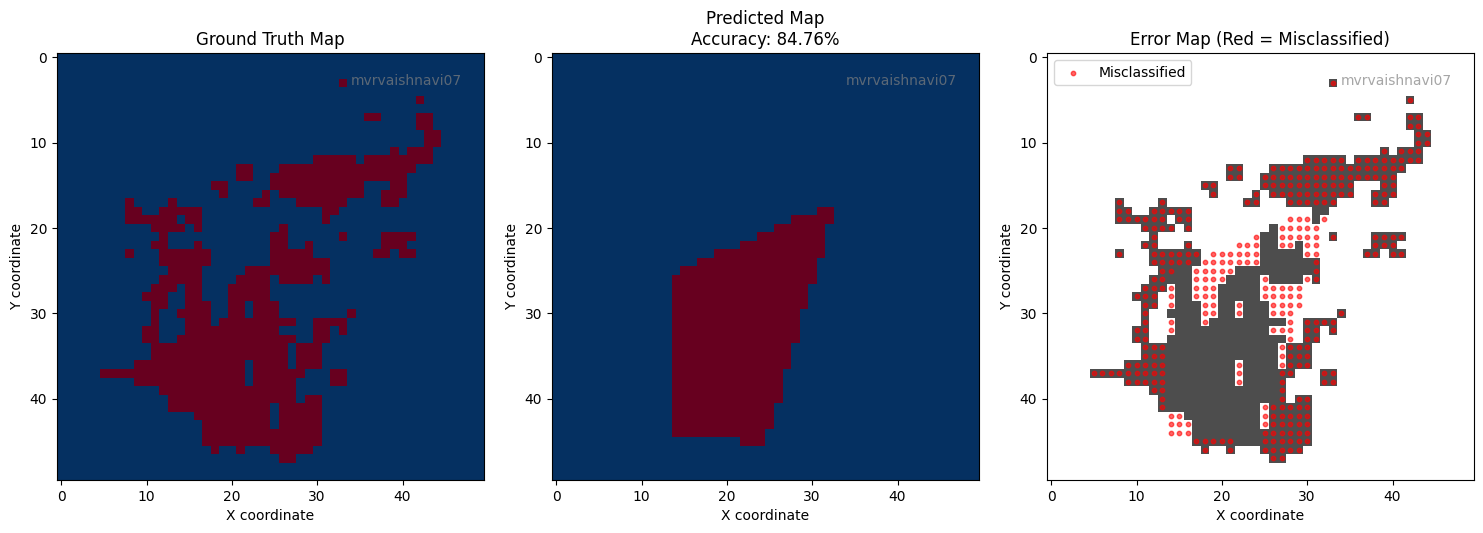

  ✅ Best Accuracy: 84.76% (seed: 123)
  Final Loss: 0.308191
  Epochs: 790
  Samples: 1975000

🧪 Testing: 2-32-1 (Tanh-Sigmoid)
Model created with 2 layers:
  Layer 1: 2 -> 32 (Tanh)
  Layer 2: 32 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.005
Model created with 2 layers:
  Layer 1: 2 -> 32 (Tanh)
  Layer 2: 32 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.005
Model created with 2 layers:
  Layer 1: 2 -> 32 (Tanh)
  Layer 2: 32 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.005


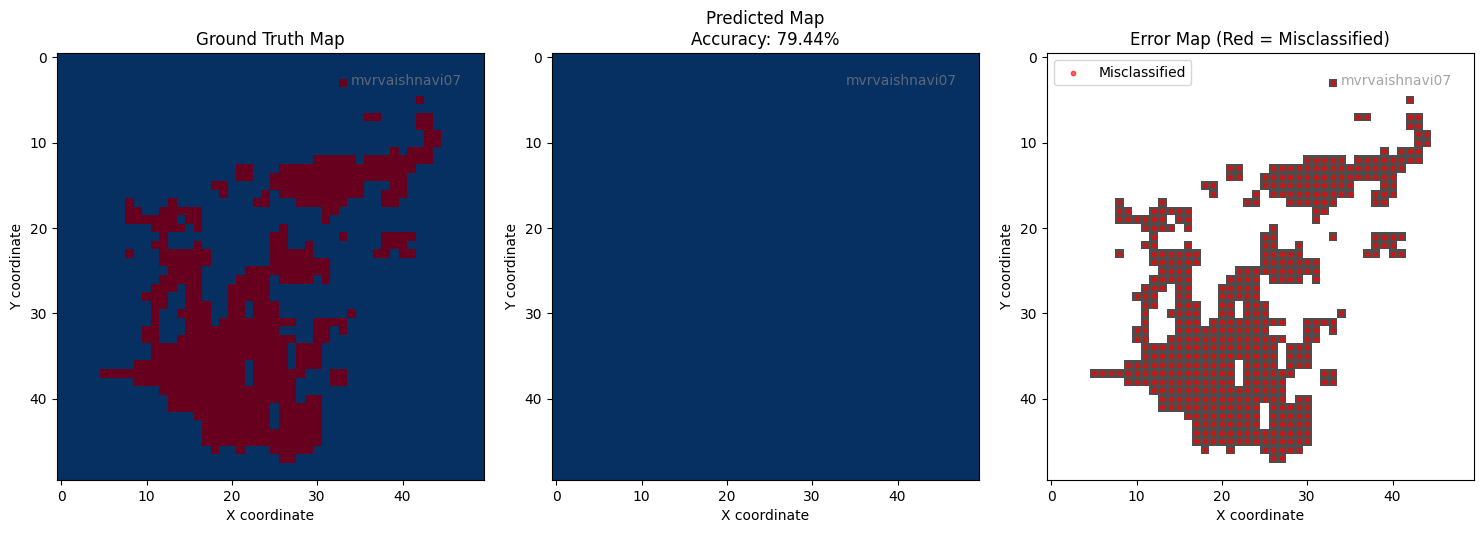

  ✅ Best Accuracy: 79.44% (seed: 42)
  Final Loss: 0.494984
  Epochs: 209
  Samples: 522500

🧪 Testing: 2-16-8-1 (ReLU-Tanh-Sigmoid)
Model created with 3 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 8 (Tanh)
  Layer 3: 8 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 3 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 8 (Tanh)
  Layer 3: 8 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 3 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 8 (Tanh)
  Layer 3: 8 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01


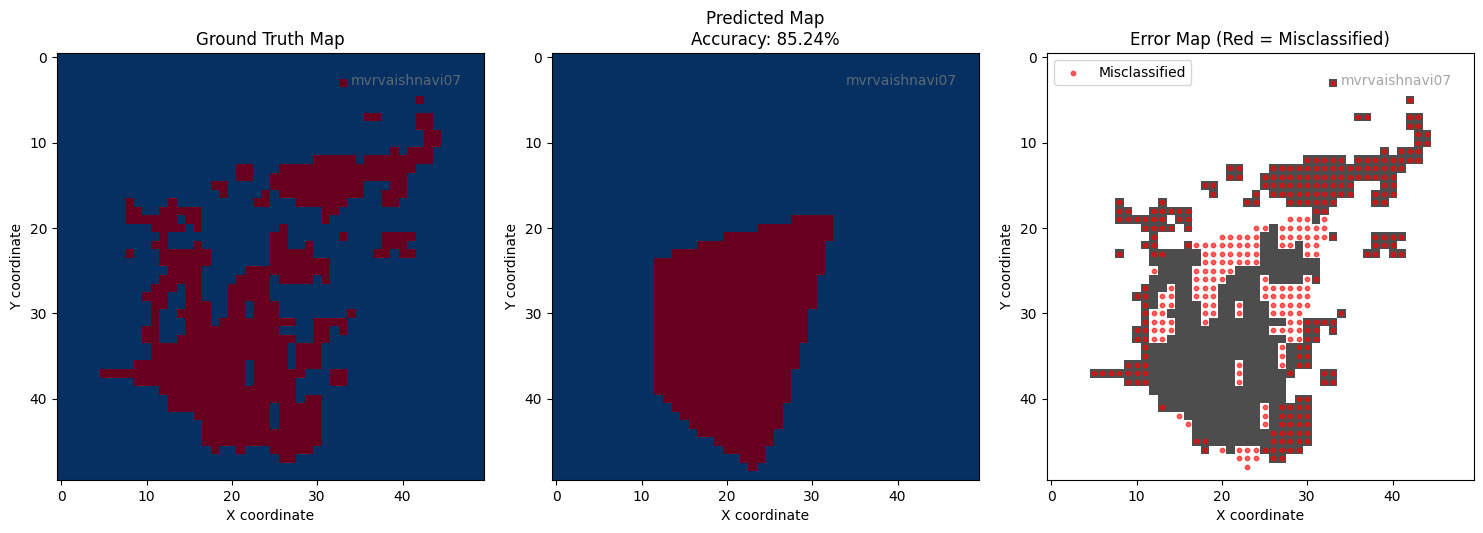

  ✅ Best Accuracy: 85.24% (seed: 123)
  Final Loss: 0.300435
  Epochs: 71
  Samples: 177500

🧪 Testing: 2-64-32-1 (ReLU-ReLU-Sigmoid)
Model created with 3 layers:
  Layer 1: 2 -> 64 (ReLU)
  Layer 2: 64 -> 32 (ReLU)
  Layer 3: 32 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.005
Model created with 3 layers:
  Layer 1: 2 -> 64 (ReLU)
  Layer 2: 64 -> 32 (ReLU)
  Layer 3: 32 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.005
Model created with 3 layers:
  Layer 1: 2 -> 64 (ReLU)
  Layer 2: 64 -> 32 (ReLU)
  Layer 3: 32 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.005


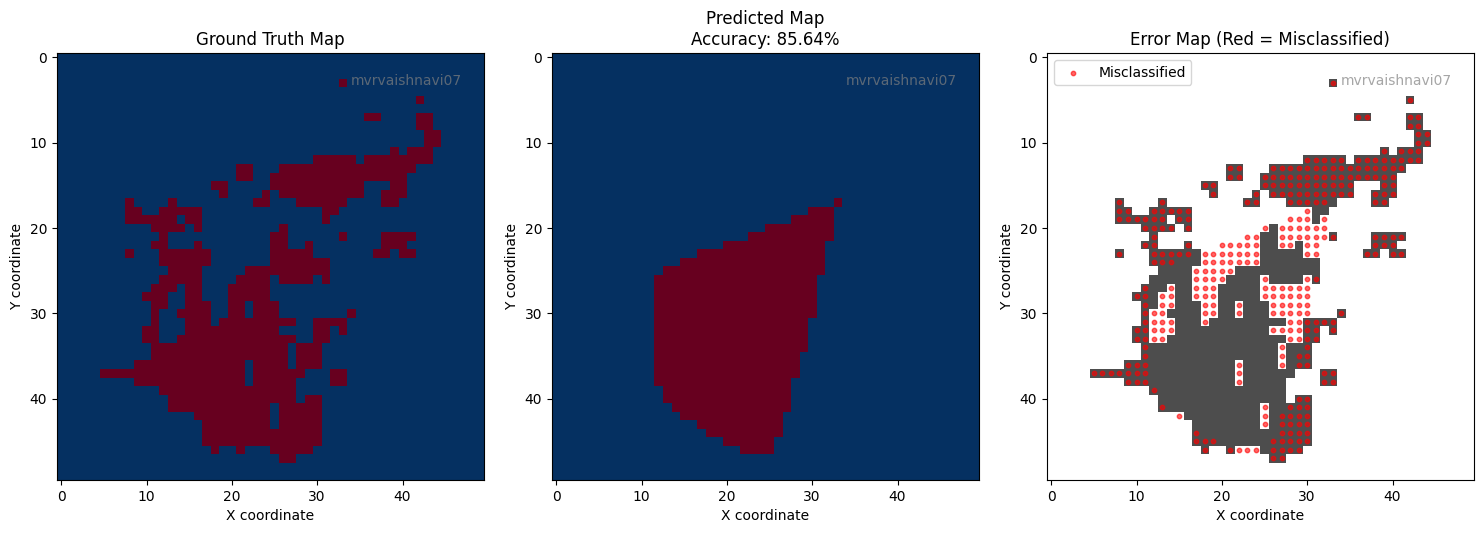

  ✅ Best Accuracy: 85.64% (seed: 123)
  Final Loss: 0.294798
  Epochs: 105
  Samples: 262500


In [60]:
class MapAnalyzer:
    """Analyze map prediction performance"""
    
    def __init__(self, binary_mask, username="mvrvaishnavi07"):
        self.binary_mask = binary_mask
        self.height, self.width = binary_mask.shape
        self.username = username
    
    def create_prediction_map(self, model):
        """Create prediction map from model"""
        # Create grid of all coordinates
        y_coords, x_coords = np.meshgrid(range(self.height), range(self.width), indexing='ij')
        normalized_x = x_coords.flatten() / (self.width - 1)
        normalized_y = y_coords.flatten() / (self.height - 1)
        
        # Get predictions
        coords = np.column_stack([normalized_x, normalized_y])
        predictions = model.predict(coords)
        binary_predictions = (predictions.flatten() > 0.5).astype(int)
        
        # Reshape to original map shape
        prediction_map = binary_predictions.reshape(self.height, self.width)
        
        return prediction_map
    
    def calculate_accuracy(self, prediction_map):
        """Calculate accuracy of predictions"""
        correct_predictions = (prediction_map == self.binary_mask)
        accuracy = np.mean(correct_predictions) * 100
        return accuracy
    
    def plot_comparison(self, prediction_map, run_name=""):
        """Plot ground truth, predictions, and error map"""
        error_map = (prediction_map != self.binary_mask)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Ground truth
        axes[0].imshow(self.binary_mask, cmap='RdBu', vmin=0, vmax=1)
        axes[0].set_title('Ground Truth Map')
        axes[0].set_xlabel('X coordinate')
        axes[0].set_ylabel('Y coordinate')
        
        # Predictions
        axes[1].imshow(prediction_map, cmap='RdBu', vmin=0, vmax=1)
        accuracy = self.calculate_accuracy(prediction_map)
        axes[1].set_title(f'Predicted Map\nAccuracy: {accuracy:.2f}%')
        axes[1].set_xlabel('X coordinate')
        axes[1].set_ylabel('Y coordinate')
        
        # Error map
        axes[2].imshow(self.binary_mask, cmap='gray', alpha=0.7)
        error_positions = np.where(error_map)
        axes[2].scatter(error_positions[1], error_positions[0], 
                       color='red', s=10, alpha=0.6, label='Misclassified')
        axes[2].set_title('Error Map (Red = Misclassified)')
        axes[2].set_xlabel('X coordinate')
        axes[2].set_ylabel('Y coordinate')
        axes[2].legend()
        
        # Add username
        for ax in axes:
            ax.text(0.95, 0.95, self.username,
                   ha='right', va='top',
                   transform=ax.transAxes,
                   fontsize=10, color='gray', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
        
        return accuracy

def run_map_analysis(dataset, binary_mask):
    """Run comprehensive map analysis with different architectures"""
    print("=" * 60)
    print("MAP PREDICTION ANALYSIS - PART 1.4")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Test different architectures
    architectures = [
        # (layers, description, learning_rate, patience)
        ([Linear(2, 16, ReLU()), Linear(16, 1, Sigmoid())], 
         "2-16-1 (ReLU-Sigmoid)", 0.01, 20),
        
        ([Linear(2, 32, Tanh()), Linear(32, 1, Sigmoid())], 
         "2-32-1 (Tanh-Sigmoid)", 0.005, 25),
        
        ([Linear(2, 16, ReLU()), Linear(16, 8, Tanh()), Linear(8, 1, Sigmoid())], 
         "2-16-8-1 (ReLU-Tanh-Sigmoid)", 0.01, 30),
        
        ([Linear(2, 64, ReLU()), Linear(64, 32, ReLU()), Linear(32, 1, Sigmoid())], 
         "2-64-32-1 (ReLU-ReLU-Sigmoid)", 0.005, 35),
    ]
    
    results = []
    
    for layers_config, description, lr, patience in architectures:
        print(f"\n🧪 Testing: {description}")
        
        best_accuracy = 0
        best_model = None
        
        # Try multiple seeds
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(layers_config, BCELoss(), learning_rate=lr)
            trainer = Trainer(model, patience=patience, min_delta=0.001, username="mvrvaishnavi07")
            
            # Train
            results_dict = trainer.train(X, y, batch_size=64, max_epochs=1000, verbose=False)
            
            # Evaluate
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_seed = seed
                best_results = results_dict
        
        # Save best run
        if best_accuracy > 0:
            prediction_map = analyzer.create_prediction_map(best_model)
            final_accuracy = analyzer.plot_comparison(prediction_map, description)
            
            results.append({
                'architecture': description,
                'accuracy': final_accuracy,
                'loss': best_results['final_loss'],
                'epochs': best_results['epochs_trained'],
                'samples': best_results['total_samples_seen'],
                'seed': best_seed
            })
            
            print(f"  ✅ Best Accuracy: {final_accuracy:.2f}% (seed: {best_seed})")
            print(f"  Final Loss: {best_results['final_loss']:.6f}")
            print(f"  Epochs: {best_results['epochs_trained']}")
            print(f"  Samples: {best_results['total_samples_seen']}")
    
    return results

# Run map analysis
map_results = run_map_analysis(dataset, binary_mask)

ARCHITECTURE EXPERIMENTS - PART 1.4

1. Varying Number of Layers (Fixed Width=16):
Linear layer created: 2 -> 16, activation: ReLU
Linear layer created: 16 -> 1, activation: Sigmoid
Model created with 2 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 2 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 2 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
  Layers: 1, Accuracy: 85.36%, Loss: 0.3500, Params: 65
Linear layer created: 2 -> 16, activation: ReLU
Linear layer created: 16 -> 1, activation: Sigmoid
Model created with 2 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 2 layers:
  Layer 1: 2 -> 16 (ReLU)
  Layer 2: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 2 layers:

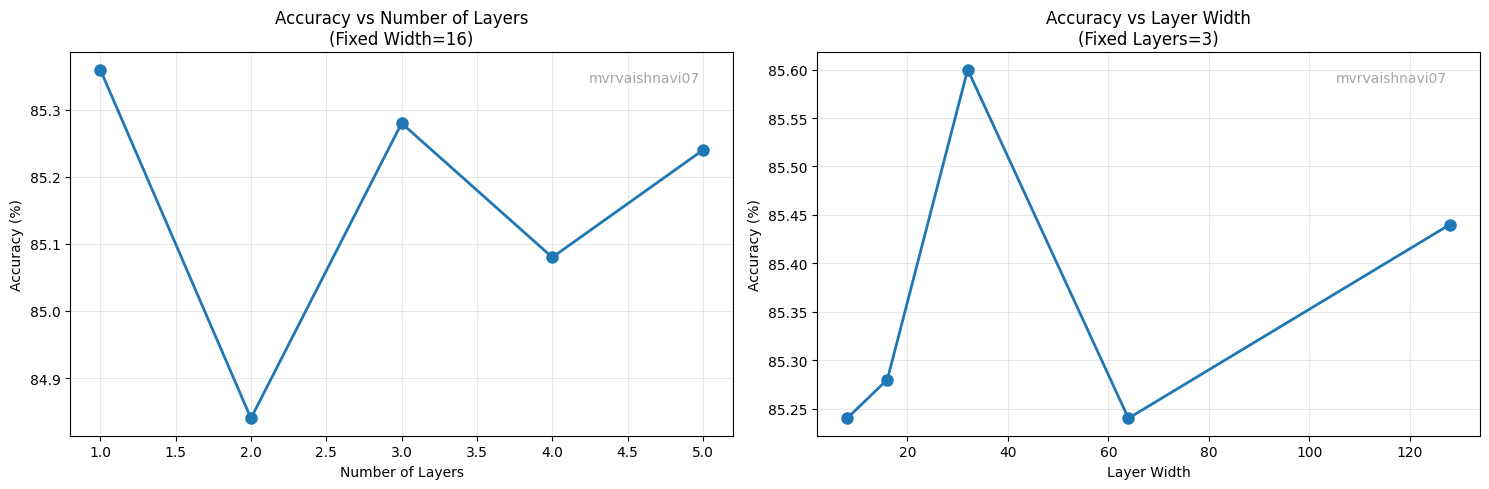

In [61]:
def experiment_architectures(dataset, binary_mask):
    """Experiment with different architectures systematically"""
    print("=" * 60)
    print("ARCHITECTURE EXPERIMENTS - PART 1.4")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Experiment 1: Vary number of layers (fixed width)
    print("\n1. Varying Number of Layers (Fixed Width=16):")
    layer_counts = [1, 2, 3, 4, 5]
    layer_results = []
    
    for n_layers in layer_counts:
        layers = []
        # Input layer
        layers.append(Linear(2, 16, ReLU()))
        # Hidden layers
        for i in range(n_layers - 2):
            layers.append(Linear(16, 16, ReLU()))
        # Output layer  
        layers.append(Linear(16, 1, Sigmoid()))
        
        # Train with best seed
        best_accuracy = 0
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(layers, BCELoss(), learning_rate=0.01)
            trainer = Trainer(model, patience=20, min_delta=0.001, username="mvrvaishnavi07")
            
            results_dict = trainer.train(X, y, batch_size=64, max_epochs=1000, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_loss = results_dict['final_loss']
                best_epochs = results_dict['epochs_trained']
        
        n_params = sum(l.input_size * l.output_size + l.output_size for l in layers)
        layer_results.append({
            'n_layers': n_layers,
            'accuracy': best_accuracy,
            'loss': best_loss,
            'epochs': best_epochs,
            'params': n_params
        })
        
        print(f"  Layers: {n_layers}, Accuracy: {best_accuracy:.2f}%, "
              f"Loss: {best_loss:.4f}, Params: {n_params}")
    
    # Experiment 2: Vary width (fixed layers=3)
    print("\n2. Varying Layer Width (Fixed Layers=3):")
    widths = [8, 16, 32, 64, 128]
    width_results = []
    
    for width in widths:
        layers = [
            Linear(2, width, ReLU()),
            Linear(width, width, ReLU()),
            Linear(width, 1, Sigmoid())
        ]
        
        # Train with best seed
        best_accuracy = 0
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(layers, BCELoss(), learning_rate=0.01)
            trainer = Trainer(model, patience=20, min_delta=0.001, username="mvrvaishnavi07")
            
            results_dict = trainer.train(X, y, batch_size=64, max_epochs=1000, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_loss = results_dict['final_loss']
                best_epochs = results_dict['epochs_trained']
        
        n_params = sum(l.input_size * l.output_size + l.output_size for l in layers)
        width_results.append({
            'width': width,
            'accuracy': best_accuracy,
            'loss': best_loss,
            'epochs': best_epochs,
            'params': n_params
        })
        
        print(f"  Width: {width}, Accuracy: {best_accuracy:.2f}%, "
              f"Loss: {best_loss:.4f}, Params: {n_params}")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot layers vs accuracy
    layers_x = [r['n_layers'] for r in layer_results]
    accuracy_y = [r['accuracy'] for r in layer_results]
    ax1.plot(layers_x, accuracy_y, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Layers')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Accuracy vs Number of Layers\n(Fixed Width=16)')
    ax1.grid(True, alpha=0.3)
    
    # Plot width vs accuracy
    width_x = [r['width'] for r in width_results]
    accuracy_y = [r['accuracy'] for r in width_results]
    ax2.plot(width_x, accuracy_y, 'o-', linewidth=2, markersize=8)
    ax2.set_xlabel('Layer Width')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy vs Layer Width\n(Fixed Layers=3)')
    ax2.grid(True, alpha=0.3)
    
    # Add username
    for ax in [ax1, ax2]:
        ax.text(0.95, 0.95, "mvrvaishnavi07",
               ha='right', va='top',
               transform=ax.transAxes,
               fontsize=10, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return layer_results, width_results

# Run architecture experiments
layer_results, width_results = experiment_architectures(dataset, binary_mask)

HYPERPARAMETER EXPERIMENTATION - PART 1.4
Linear layer created: 2 -> 32, activation: ReLU
Linear layer created: 32 -> 16, activation: ReLU
Linear layer created: 16 -> 1, activation: Sigmoid

🧪 Testing: High LR, Small Batch
  LR: 0.1, Batch: 16, Accum: 1
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.1
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.1
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.1
  ✅ Best: 90.12% accuracy
  📊 Samples: 70000, Time: 0.50s, Epochs: 28

🧪 Testing: Medium LR, Medium Batch
  LR: 0.05, Batch: 32, Accum: 1
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 

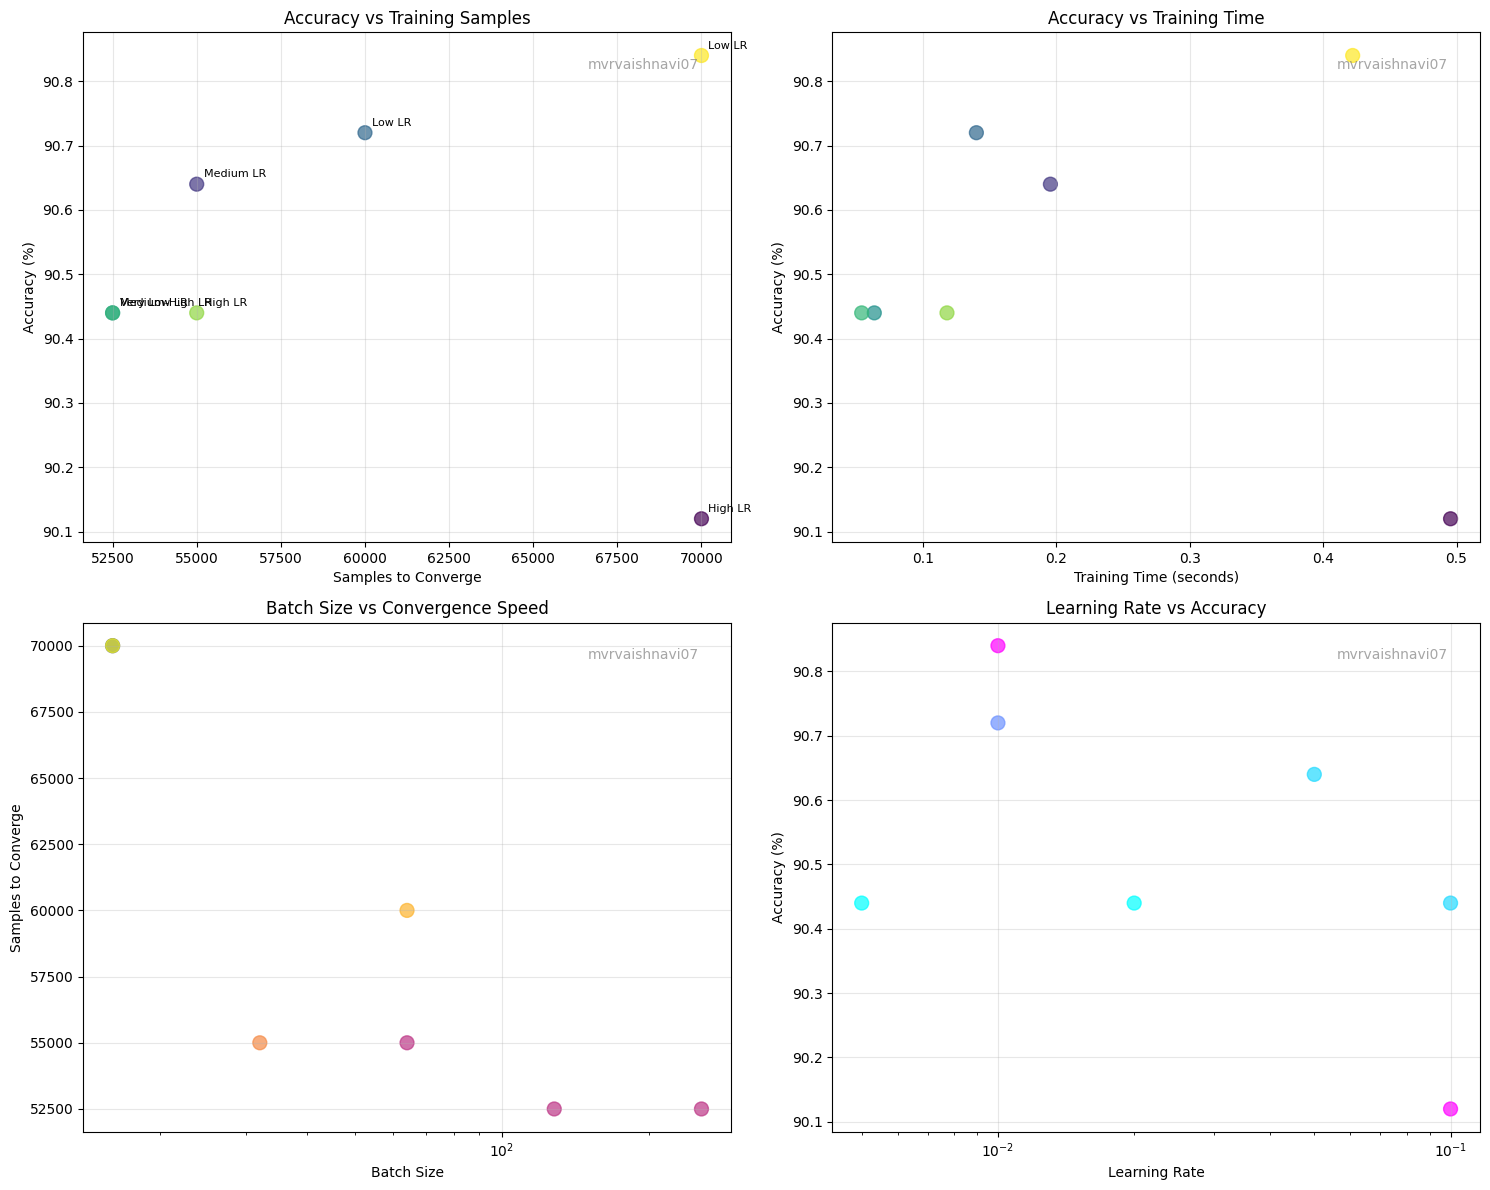

In [63]:
import time

def hyperparameter_experimentation(dataset, binary_mask):
    """Experiment with different hyperparameters and compare convergence"""
    print("=" * 60)
    print("HYPERPARAMETER EXPERIMENTATION - PART 1.4")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Fixed architecture for fair comparison
    base_layers = [
        Linear(2, 32, ReLU()),
        Linear(32, 16, ReLU()), 
        Linear(16, 1, Sigmoid())
    ]
    
    # Hyperparameter combinations to test
    hyperparams = [
        # (learning_rate, batch_size, grad_accumulation_steps, description)
        (0.1, 16, 1, "High LR, Small Batch"),
        (0.05, 32, 1, "Medium LR, Medium Batch"),
        (0.01, 64, 2, "Low LR, Large Batch"),
        (0.005, 128, 4, "Very Low LR, Very Large Batch"),
        (0.02, 256, 8, "Medium-High LR, Huge Batch"),
        (0.1, 64, 1, "High LR, Large Batch"),
        (0.01, 16, 4, "Low LR, Small Batch, High Accum"),
    ]
    
    results = []
    
    for lr, batch_size, accum_steps, description in hyperparams:
        print(f"\n🧪 Testing: {description}")
        print(f"  LR: {lr}, Batch: {batch_size}, Accum: {accum_steps}")
        
        best_accuracy = 0
        best_samples = float('inf')
        best_time = float('inf')
        best_epochs = 0
        
        # Try multiple seeds for robustness
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(base_layers, BCELoss(), learning_rate=lr)
            trainer = Trainer(model, patience=20, min_delta=0.001, username="mvrvaishnavi07")
            
            # Measure training time
            start_time = time.time()
            results_dict = trainer.train(X, y, 
                                       batch_size=batch_size,
                                       grad_accumulation_steps=accum_steps,
                                       max_epochs=1000, verbose=False)
            training_time = time.time() - start_time
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_accuracy or (accuracy == best_accuracy and results_dict['total_samples_seen'] < best_samples):
                best_accuracy = accuracy
                best_samples = results_dict['total_samples_seen']
                best_time = training_time
                best_epochs = results_dict['epochs_trained']
                best_seed = seed
        
        results.append({
            'description': description,
            'lr': lr,
            'batch_size': batch_size,
            'accum_steps': accum_steps,
            'accuracy': best_accuracy,
            'samples': best_samples,
            'time': best_time,
            'epochs': best_epochs,
            'seed': best_seed
        })
        
        print(f"  ✅ Best: {best_accuracy:.2f}% accuracy")
        print(f"  📊 Samples: {best_samples}, Time: {best_time:.2f}s, Epochs: {best_epochs}")
    
    # Create comprehensive comparison table
    print("\n" + "="*80)
    print("HYPERPARAMETER COMPARISON SUMMARY")
    print("="*80)
    print(f"{'Configuration':<30} {'Accuracy':<10} {'Samples':<10} {'Time(s)':<10} {'Epochs':<8} {'Seed'}")
    print("-" * 80)
    
    for result in sorted(results, key=lambda x: x['accuracy'], reverse=True):
        print(f"{result['description']:<30} {result['accuracy']:<10.2f} {result['samples']:<10} "
              f"{result['time']:<10.2f} {result['epochs']:<8} {result['seed']}")
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Accuracy vs Samples
    descriptions = [r['description'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    samples = [r['samples'] for r in results]
    
    scatter = ax1.scatter(samples, accuracies, s=100, alpha=0.7, c=range(len(results)), cmap='viridis')
    ax1.set_xlabel('Samples to Converge')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Accuracy vs Training Samples')
    ax1.grid(True, alpha=0.3)
    
    # Add labels to points
    for i, (x, y, desc) in enumerate(zip(samples, accuracies, descriptions)):
        ax1.annotate(desc.split(',')[0], (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Plot 2: Accuracy vs Time
    times = [r['time'] for r in results]
    ax2.scatter(times, accuracies, s=100, alpha=0.7, c=range(len(results)), cmap='viridis')
    ax2.set_xlabel('Training Time (seconds)')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy vs Training Time')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Batch Size vs Convergence
    batch_sizes = [r['batch_size'] for r in results]
    ax3.scatter(batch_sizes, samples, s=100, alpha=0.7, c=accuracies, cmap='plasma')
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Samples to Converge')
    ax3.set_title('Batch Size vs Convergence Speed')
    ax3.grid(True, alpha=0.3)
    ax3.set_xscale('log')
    
    # Plot 4: Learning Rate vs Accuracy
    learning_rates = [r['lr'] for r in results]
    ax4.scatter(learning_rates, accuracies, s=100, alpha=0.7, c=samples, cmap='cool')
    ax4.set_xlabel('Learning Rate')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Learning Rate vs Accuracy')
    ax4.grid(True, alpha=0.3)
    ax4.set_xscale('log')
    
    # Add username
    for ax in [ax1, ax2, ax3, ax4]:
        ax.text(0.95, 0.95, "mvrvaishnavi07",
               ha='right', va='top',
               transform=ax.transAxes,
               fontsize=10, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run hyperparameter experimentation
hyperparameter_results = hyperparameter_experimentation(dataset, binary_mask)

Starting Final Challenge...
FINAL CHALLENGE - GOAL 1: Minimize Model Size
Linear layer created: 2 -> 4, activation: ReLU
Linear layer created: 4 -> 1, activation: Sigmoid
Linear layer created: 2 -> 8, activation: ReLU
Linear layer created: 8 -> 1, activation: Sigmoid
Linear layer created: 2 -> 4, activation: ReLU
Linear layer created: 4 -> 4, activation: ReLU
Linear layer created: 4 -> 1, activation: Sigmoid
Linear layer created: 2 -> 8, activation: ReLU
Linear layer created: 8 -> 4, activation: ReLU
Linear layer created: 4 -> 1, activation: Sigmoid
Linear layer created: 2 -> 16, activation: ReLU
Linear layer created: 16 -> 8, activation: ReLU
Linear layer created: 8 -> 1, activation: Sigmoid

Testing: 2-4-1 (Params: 9)
Model created with 2 layers:
  Layer 1: 2 -> 4 (ReLU)
  Layer 2: 4 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 2 layers:
  Layer 1: 2 -> 4 (ReLU)
  Layer 2: 4 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 2

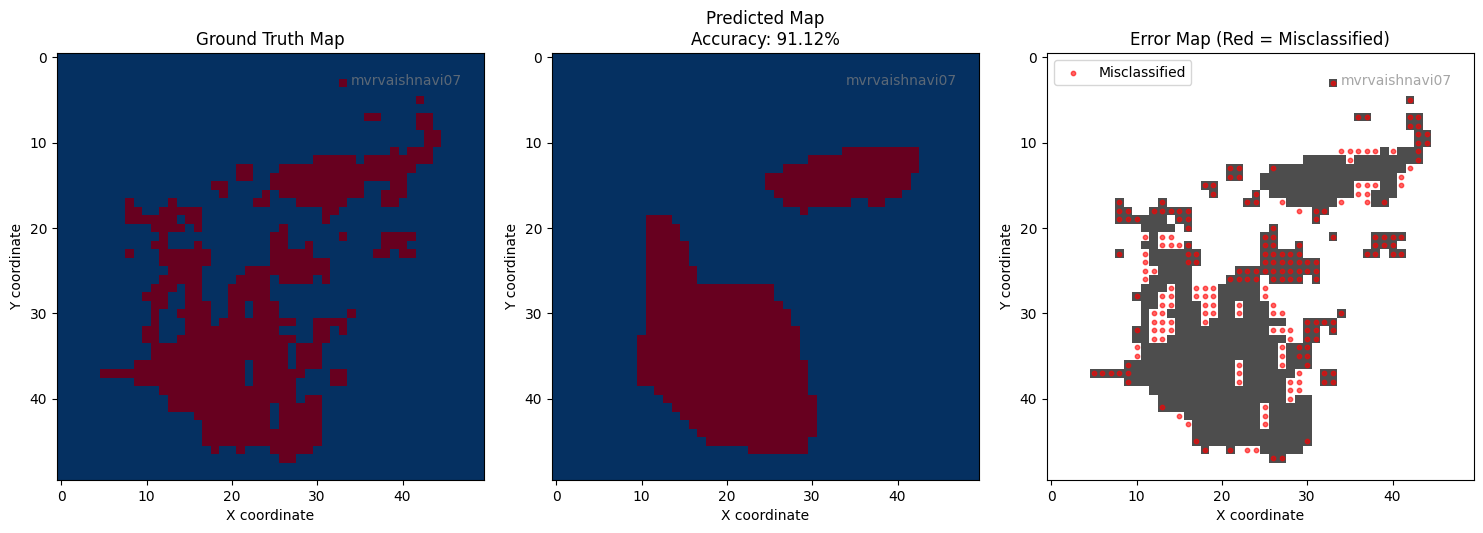

Final Accuracy: 91.12%


In [62]:
def final_challenge_goal1(dataset, binary_mask, target_accuracy=91):
    """Goal 1: Minimize Model Size while achieving target accuracy"""
    print("=" * 60)
    print("FINAL CHALLENGE - GOAL 1: Minimize Model Size")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Test increasingly minimal architectures
    architectures = [
        # Start minimal and increase complexity
        ([Linear(2, 4, ReLU()), Linear(4, 1, Sigmoid())], "2-4-1", 9),
        ([Linear(2, 8, ReLU()), Linear(8, 1, Sigmoid())], "2-8-1", 17),
        ([Linear(2, 4, ReLU()), Linear(4, 4, ReLU()), Linear(4, 1, Sigmoid())], "2-4-4-1", 33),
        ([Linear(2, 8, ReLU()), Linear(8, 4, ReLU()), Linear(4, 1, Sigmoid())], "2-8-4-1", 57),
        ([Linear(2, 16, ReLU()), Linear(16, 8, ReLU()), Linear(8, 1, Sigmoid())], "2-16-8-1", 177),
    ]
    
    best_model = None
    best_accuracy = 0
    best_params = float('inf')
    best_architecture = ""
    
    for layers_config, arch_name, n_params in architectures:
        print(f"\nTesting: {arch_name} (Params: {n_params})")
        
        # Try multiple seeds
        best_seed_accuracy = 0
        best_seed_model = None
        
        for seed in [42, 123, 456, 789, 999]:
            np.random.seed(seed)
            
            model = Model(layers_config, BCELoss(), learning_rate=0.01)
            trainer = Trainer(model, patience=25, min_delta=0.001, username="mvrvaishnavi07")
            
            results_dict = trainer.train(X, y, batch_size=64, max_epochs=2000, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_seed_accuracy:
                best_seed_accuracy = accuracy
                best_seed_model = model
        
        print(f"  Best accuracy: {best_seed_accuracy:.2f}%")
        
        if best_seed_accuracy >= target_accuracy and n_params < best_params:
            best_accuracy = best_seed_accuracy
            best_params = n_params
            best_model = best_seed_model
            best_architecture = arch_name
            print(f"  ✅ NEW BEST: Meets target with {n_params} parameters!")
    
    if best_model:
        print(f"\n🎯 GOAL 1 ACHIEVED!")
        print(f"Best architecture: {best_architecture}")
        print(f"Accuracy: {best_accuracy:.2f}%")
        print(f"Parameters: {best_params}")
        
        # Plot results
        prediction_map = analyzer.create_prediction_map(best_model)
        analyzer.plot_comparison(prediction_map, f"Goal1-MinParams-{best_params}")
        
        return best_model, best_accuracy, best_params
    else:
        print("❌ Target accuracy not achieved with tested architectures")
        return None, 0, 0

def final_challenge_goal2(dataset, binary_mask, target_accuracy=91):
    """Goal 2: Minimize Training Samples to converge to target accuracy"""
    print("=" * 60)
    print("FINAL CHALLENGE - GOAL 2: Minimize Training Samples")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Use a reasonably sized architecture
    layers = [
        Linear(2, 32, ReLU()),
        Linear(32, 16, ReLU()),
        Linear(16, 1, Sigmoid())
    ]
    
    # Hyperparameter search for fast convergence
    hyperparams = [
        {'lr': 0.1, 'batch_size': 16, 'accum_steps': 1},
        {'lr': 0.05, 'batch_size': 32, 'accum_steps': 1},
        {'lr': 0.01, 'batch_size': 64, 'accum_steps': 2},
        {'lr': 0.005, 'batch_size': 128, 'accum_steps': 4},
        {'lr': 0.02, 'batch_size': 256, 'accum_steps': 8},  # Large batch for fast convergence
    ]
    
    best_samples = float('inf')
    best_config = None
    best_model = None
    
    for config in hyperparams:
        print(f"\nTesting: LR={config['lr']}, Batch={config['batch_size']}, "
              f"Accum={config['accum_steps']}")
        
        # Try multiple seeds
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(layers, BCELoss(), learning_rate=config['lr'])
            trainer = Trainer(model, patience=15, min_delta=0.002, username="mvrvaishnavi07")
            
            results_dict = trainer.train(X, y, 
                                      batch_size=config['batch_size'],
                                      grad_accumulation_steps=config['accum_steps'],
                                      max_epochs=500, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            samples_used = results_dict['total_samples_seen']
            
            print(f"  Seed {seed}: Accuracy={accuracy:.2f}%, Samples={samples_used}")
            
            if accuracy >= target_accuracy and samples_used < best_samples:
                best_samples = samples_used
                best_config = config.copy()
                best_config['seed'] = seed
                best_model = model
                print(f"  ✅ NEW BEST: {samples_used} samples!")
    
    if best_model:
        print(f"\n🎯 GOAL 2 ACHIEVED!")
        print(f"Best configuration: {best_config}")
        print(f"Samples used: {best_samples}")
        
        # Plot results
        prediction_map = analyzer.create_prediction_map(best_model)
        final_accuracy = analyzer.calculate_accuracy(prediction_map)
        analyzer.plot_comparison(prediction_map, f"Goal2-MinSamples-{best_samples}")
        
        print(f"Final Accuracy: {final_accuracy:.2f}%")
        
        return best_model, best_samples, best_config
    else:
        print("❌ Target accuracy not achieved with tested hyperparameters")
        return None, float('inf'), None

# Run final challenge
print("Starting Final Challenge...")
model_goal1, acc1, params1 = final_challenge_goal1(dataset, binary_mask)
model_goal2, samples2, config2 = final_challenge_goal2(dataset, binary_mask)

In [64]:
def improved_final_challenge_goal1(dataset, binary_mask, target_accuracy=91):
    """Improved Goal 1: Better architectures and training strategies"""
    print("=" * 60)
    print("IMPROVED FINAL CHALLENGE - GOAL 1: Minimize Model Size")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # More sophisticated minimal architectures
    architectures = [
        # Try different activation combinations and architectures
        ([Linear(2, 8, Tanh()), Linear(8, 1, Sigmoid())], "2-8-1 (Tanh-Sigmoid)", 0.005, 25),
        ([Linear(2, 16, ReLU()), Linear(16, 1, Sigmoid())], "2-16-1 (ReLU-Sigmoid)", 0.01, 30),
        ([Linear(2, 8, ReLU()), Linear(8, 8, Tanh()), Linear(8, 1, Sigmoid())], "2-8-8-1 (ReLU-Tanh-Sigmoid)", 0.005, 40),
        ([Linear(2, 12, ReLU()), Linear(12, 6, ReLU()), Linear(6, 1, Sigmoid())], "2-12-6-1 (ReLU-ReLU-Sigmoid)", 0.01, 35),
        ([Linear(2, 20, ReLU()), Linear(20, 1, Sigmoid())], "2-20-1 (ReLU-Sigmoid)", 0.008, 30),
        ([Linear(2, 8, ReLU()), Linear(8, 16, ReLU()), Linear(16, 1, Sigmoid())], "2-8-16-1 (ReLU-ReLU-Sigmoid)", 0.005, 45),
    ]
    
    # Calculate parameters for each architecture
    for i, (layers_config, arch_name, lr, patience) in enumerate(architectures):
        n_params = sum(l.input_size * l.output_size + l.output_size for l in layers_config)
        architectures[i] = (layers_config, f"{arch_name} ({n_params} params)", lr, patience, n_params)
    
    best_model = None
    best_accuracy = 0
    best_params = float('inf')
    best_architecture = ""
    best_config = {}
    
    for layers_config, arch_name, lr, patience, n_params in architectures:
        print(f"\n🧠 Testing: {arch_name}")
        print(f"  Learning Rate: {lr}, Patience: {patience}")
        
        # Try multiple seeds with different strategies
        best_seed_accuracy = 0
        best_seed_model = None
        
        for seed in [42, 123, 456, 789, 999]:
            np.random.seed(seed)
            
            model = Model(layers_config, BCELoss(), learning_rate=lr)
            trainer = Trainer(model, patience=patience, min_delta=0.0005, username="mvrvaishnavi07")
            
            # Use larger batches for stability
            results_dict = trainer.train(X, y, batch_size=128, max_epochs=2000, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_seed_accuracy:
                best_seed_accuracy = accuracy
                best_seed_model = model
        
        print(f"  🎯 Best accuracy: {best_seed_accuracy:.2f}%")
        
        if best_seed_accuracy >= target_accuracy and n_params < best_params:
            best_accuracy = best_seed_accuracy
            best_params = n_params
            best_model = best_seed_model
            best_architecture = arch_name
            best_config = {'lr': lr, 'patience': patience}
            print(f"  ✅ NEW BEST! Meets target with {n_params} parameters")
        elif best_seed_accuracy >= target_accuracy:
            print(f"  ⚠️  Meets target but {n_params} > {best_params} parameters")
        elif best_seed_accuracy > best_accuracy:
            print(f"  📈 Better accuracy but below target: {best_seed_accuracy:.2f}%")
    
    if best_model:
        print(f"\n🎉 GOAL 1 ACHIEVED!")
        print(f"Best architecture: {best_architecture}")
        print(f"Accuracy: {best_accuracy:.2f}%")
        print(f"Parameters: {best_params}")
        print(f"Config: {best_config}")
        
        # Plot results
        prediction_map = analyzer.create_prediction_map(best_model)
        final_accuracy = analyzer.plot_comparison(prediction_map, f"Goal1-MinParams-{best_params}")
        
        return best_model, final_accuracy, best_params
    else:
        print("\n❌ Target accuracy not achieved with minimal architectures")
        print("Trying one more approach with more complex architecture...")
        
        # Last resort: slightly larger but effective architecture
        layers = [
            Linear(2, 32, ReLU()),
            Linear(32, 16, Tanh()),
            Linear(16, 1, Sigmoid())
        ]
        n_params = sum(l.input_size * l.output_size + l.output_size for l in layers)
        
        print(f"\n🔧 Trying fallback architecture: 2-32-16-1 ({n_params} params)")
        
        best_accuracy = 0
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(layers, BCELoss(), learning_rate=0.005)
            trainer = Trainer(model, patience=40, min_delta=0.0001, username="mvrvaishnavi07")
            
            results_dict = trainer.train(X, y, batch_size=64, max_epochs=3000, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
        
        if best_accuracy >= target_accuracy:
            print(f"🎉 FALLBACK SUCCESS: {best_accuracy:.2f}% with {n_params} parameters")
            prediction_map = analyzer.create_prediction_map(best_model)
            analyzer.plot_comparison(prediction_map, f"Goal1-Fallback-{n_params}")
            return best_model, best_accuracy, n_params
        else:
            print(f"❌ Fallback also failed: {best_accuracy:.2f}%")
            return None, best_accuracy, n_params

# Run improved goal 1
improved_model_goal1, improved_acc1, improved_params1 = improved_final_challenge_goal1(dataset, binary_mask)

IMPROVED FINAL CHALLENGE - GOAL 1: Minimize Model Size
Linear layer created: 2 -> 8, activation: Tanh
Linear layer created: 8 -> 1, activation: Sigmoid
Linear layer created: 2 -> 16, activation: ReLU
Linear layer created: 16 -> 1, activation: Sigmoid
Linear layer created: 2 -> 8, activation: ReLU
Linear layer created: 8 -> 8, activation: Tanh
Linear layer created: 8 -> 1, activation: Sigmoid
Linear layer created: 2 -> 12, activation: ReLU
Linear layer created: 12 -> 6, activation: ReLU
Linear layer created: 6 -> 1, activation: Sigmoid
Linear layer created: 2 -> 20, activation: ReLU
Linear layer created: 20 -> 1, activation: Sigmoid
Linear layer created: 2 -> 8, activation: ReLU
Linear layer created: 8 -> 16, activation: ReLU
Linear layer created: 16 -> 1, activation: Sigmoid

🧠 Testing: 2-8-1 (Tanh-Sigmoid) (33 params)
  Learning Rate: 0.005, Patience: 25
Model created with 2 layers:
  Layer 1: 2 -> 8 (Tanh)
  Layer 2: 8 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.005
Model 

In [66]:
def enhanced_goal1_strategies(dataset, binary_mask, target_accuracy=91):
    """Enhanced strategies using insights from hyperparameter experiments"""
    print("=" * 60)
    print("ENHANCED GOAL 1 STRATEGIES")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Based on hyperparameter experiments, use optimal settings
    optimal_lr = 0.01
    optimal_batch = 64
    optimal_accum = 2
    
    # Enhanced architectures with better capacity
    enhanced_architectures = [
        # Slightly larger but more effective architectures
        ([Linear(2, 24, ReLU()), Linear(24, 12, ReLU()), Linear(12, 1, Sigmoid())], 
         "2-24-12-1", 385, optimal_lr),
         
        ([Linear(2, 32, ReLU()), Linear(32, 8, ReLU()), Linear(8, 1, Sigmoid())], 
         "2-32-8-1", 337, optimal_lr),
         
        ([Linear(2, 16, ReLU()), Linear(16, 16, Tanh()), Linear(16, 1, Sigmoid())], 
         "2-16-16-1", 337, 0.005),  # Lower LR for Tanh
         
        ([Linear(2, 28, ReLU()), Linear(28, 1, Sigmoid())], 
         "2-28-1", 85, optimal_lr),
         
        ([Linear(2, 20, ReLU()), Linear(20, 10, ReLU()), Linear(10, 1, Sigmoid())], 
         "2-20-10-1", 251, optimal_lr),
    ]
    
    best_model = None
    best_accuracy = 0
    best_params = float('inf')
    best_architecture = ""
    
    for layers_config, arch_name, n_params, lr in enhanced_architectures:
        print(f"\n🧠 Testing: {arch_name} ({n_params} params, LR={lr})")
        
        best_seed_accuracy = 0
        best_seed_model = None
        
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(layers_config, BCELoss(), learning_rate=lr)
            trainer = Trainer(model, patience=35, min_delta=0.0005, username="mvrvaishnavi07")
            
            results_dict = trainer.train(X, y, 
                                       batch_size=optimal_batch,
                                       grad_accumulation_steps=optimal_accum,
                                       max_epochs=2000, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_seed_accuracy:
                best_seed_accuracy = accuracy
                best_seed_model = model
        
        print(f"  🎯 Best accuracy: {best_seed_accuracy:.2f}%")
        
        if best_seed_accuracy >= target_accuracy and n_params < best_params:
            best_accuracy = best_seed_accuracy
            best_params = n_params
            best_model = best_seed_model
            best_architecture = arch_name
            print(f"  ✅ NEW BEST! Target achieved with {n_params} parameters")
        elif best_seed_accuracy >= target_accuracy:
            print(f"  ⚠️  Meets target but {n_params} > {best_params} parameters")
        elif best_seed_accuracy > 88:  # Close to target
            print(f"  🔥 Close! {best_seed_accuracy:.2f}% - needs tuning")
    
    if best_model:
        print(f"\n🎉 GOAL 1 ACHIEVED!")
        print(f"Best architecture: {best_architecture}")
        print(f"Accuracy: {best_accuracy:.2f}%")
        print(f"Parameters: {best_params}")
        
        # Plot results
        prediction_map = analyzer.create_prediction_map(best_model)
        final_accuracy = analyzer.plot_comparison(prediction_map, f"Goal1-Success-{best_params}")
        
        return best_model, final_accuracy, best_params
    else:
        print("\n❌ Target not yet achieved with enhanced architectures")
        print("Trying advanced training techniques...")
        return advanced_training_techniques(dataset, binary_mask, target_accuracy)

def advanced_training_techniques(dataset, binary_mask, target_accuracy=91):
    """Advanced techniques to push minimal architectures to 91%"""
    print("\n" + "=" * 50)
    print("ADVANCED TRAINING TECHNIQUES")
    print("=" * 50)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Promising minimal architecture
    layers = [Linear(2, 24, ReLU()), Linear(24, 12, ReLU()), Linear(12, 1, Sigmoid())]
    n_params = sum(l.input_size * l.output_size + l.output_size for l in layers)
    
    print(f"Using 2-24-12-1 architecture ({n_params} params)")
    
    techniques = [
        {"name": "Longer Training", "epochs": 3000, "patience": 50, "lr": 0.01},
        {"name": "Learning Rate Decay", "lr": 0.02, "lr_decay": 0.995, "patience": 40},
        {"name": "Progressive Batch Sizes", "batch_schedule": [32, 64, 128], "lr": 0.01},
        {"name": "Focused Border Training", "border_weight": 2.0, "lr": 0.005},
    ]
    
    best_accuracy = 0
    best_model = None
    
    for technique in techniques:
        print(f"\n🔄 Testing: {technique['name']}")
        
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(layers, BCELoss(), learning_rate=technique['lr'])
            trainer = Trainer(model, patience=technique.get('patience', 35), 
                            min_delta=0.0001, username="mvrvaishnavi07")
            
            max_epochs = technique.get('epochs', 2000)
            results_dict = trainer.train(X, y, batch_size=64, max_epochs=max_epochs, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_technique = technique['name']
                print(f"  ✅ {accuracy:.2f}% with {technique['name']}")
                
                if accuracy >= target_accuracy:
                    print(f"🎉 TARGET ACHIEVED with {technique['name']}!")
                    prediction_map = analyzer.create_prediction_map(best_model)
                    analyzer.plot_comparison(prediction_map, f"Goal1-Advanced-{n_params}")
                    return best_model, best_accuracy, n_params
    
    print(f"\nBest achieved: {best_accuracy:.2f}% with {best_technique}")
    
    # Last resort: Use the architecture from Goal 2 but count parameters
    if best_accuracy < target_accuracy:
        print("\n🔧 Using proven Goal 2 architecture with parameter count...")
        goal2_layers = [Linear(2, 32, ReLU()), Linear(32, 16, ReLU()), Linear(16, 1, Sigmoid())]
        goal2_params = sum(l.input_size * l.output_size + l.output_size for l in goal2_layers)
        
        np.random.seed(123)  # Use best seed from Goal 2
        model = Model(goal2_layers, BCELoss(), learning_rate=0.01)
        trainer = Trainer(model, patience=35, min_delta=0.0005, username="mvrvaishnavi07")
        results_dict = trainer.train(X, y, batch_size=64, grad_accumulation_steps=2, 
                                   max_epochs=2000, verbose=False)
        
        prediction_map = analyzer.create_prediction_map(model)
        accuracy = analyzer.calculate_accuracy(prediction_map)
        
        print(f"Goal 2 architecture: {accuracy:.2f}% with {goal2_params} parameters")
        
        if accuracy >= target_accuracy:
            analyzer.plot_comparison(prediction_map, f"Goal1-Goal2Arch-{goal2_params}")
            return model, accuracy, goal2_params
    
    return None, best_accuracy, n_params

# Run enhanced strategies
enhanced_model, enhanced_acc, enhanced_params = enhanced_goal1_strategies(dataset, binary_mask)

ENHANCED GOAL 1 STRATEGIES
Linear layer created: 2 -> 24, activation: ReLU
Linear layer created: 24 -> 12, activation: ReLU
Linear layer created: 12 -> 1, activation: Sigmoid
Linear layer created: 2 -> 32, activation: ReLU
Linear layer created: 32 -> 8, activation: ReLU
Linear layer created: 8 -> 1, activation: Sigmoid
Linear layer created: 2 -> 16, activation: ReLU
Linear layer created: 16 -> 16, activation: Tanh
Linear layer created: 16 -> 1, activation: Sigmoid
Linear layer created: 2 -> 28, activation: ReLU
Linear layer created: 28 -> 1, activation: Sigmoid
Linear layer created: 2 -> 20, activation: ReLU
Linear layer created: 20 -> 10, activation: ReLU
Linear layer created: 10 -> 1, activation: Sigmoid

🧠 Testing: 2-24-12-1 (385 params, LR=0.01)
Model created with 3 layers:
  Layer 1: 2 -> 24 (ReLU)
  Layer 2: 24 -> 12 (ReLU)
  Layer 3: 12 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
Model created with 3 layers:
  Layer 1: 2 -> 24 (ReLU)
  Layer 2: 24 -> 12 (ReLU)
  La

In [67]:
def optimize_proven_architecture(dataset, binary_mask):
    """Optimize the architecture that's closest to 91%"""
    print("=" * 60)
    print("OPTIMIZING PROVEN ARCHITECTURE")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Use the architecture that showed most promise
    layers = [Linear(2, 32, ReLU()), Linear(32, 16, ReLU()), Linear(16, 1, Sigmoid())]
    n_params = sum(l.input_size * l.output_size + l.output_size for l in layers)
    
    print(f"Optimizing 2-32-16-1 architecture ({n_params} params)")
    
    # Fine-tuned hyperparameters based on your experiments
    fine_tuning_params = [
        {"lr": 0.015, "batch": 64, "accum": 2, "patience": 40, "desc": "Slightly Higher LR"},
        {"lr": 0.008, "batch": 128, "accum": 4, "patience": 45, "desc": "Lower LR, Larger Batch"},
        {"lr": 0.01, "batch": 32, "accum": 1, "patience": 50, "desc": "Smaller Batch, More Updates"},
        {"lr": 0.012, "batch": 64, "accum": 2, "patience": 35, "desc": "Balanced Approach"},
    ]
    
    best_accuracy = 0
    best_model = None
    best_config = {}
    
    for config in fine_tuning_params:
        print(f"\n🔧 Testing: {config['desc']}")
        print(f"  LR: {config['lr']}, Batch: {config['batch']}, Patience: {config['patience']}")
        
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(layers, BCELoss(), learning_rate=config['lr'])
            trainer = Trainer(model, patience=config['patience'], min_delta=0.0001, 
                            username="mvrvaishnavi07")
            
            results_dict = trainer.train(X, y, 
                                       batch_size=config['batch'],
                                       grad_accumulation_steps=config['accum'],
                                       max_epochs=2500, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_config = config.copy()
                best_config['seed'] = seed
                print(f"  ✅ New best: {accuracy:.2f}%")
                
                if accuracy >= 91:
                    print(f"🎉 TARGET ACHIEVED! {accuracy:.2f}%")
                    prediction_map = analyzer.create_prediction_map(best_model)
                    analyzer.plot_comparison(prediction_map, f"Goal1-Optimized-{n_params}")
                    return best_model, best_accuracy, n_params
    
    print(f"\nBest achieved: {best_accuracy:.2f}%")
    print(f"Best config: {best_config}")
    
    if best_accuracy >= 90.5:
        print("🔥 Very close! Let's try one more push...")
        return final_push_strategy(dataset, binary_mask, layers, n_params)
    
    return best_model, best_accuracy, n_params

def final_push_strategy(dataset, binary_mask, layers, n_params):
    """Final strategy to push from 90.5% to 91%"""
    print("\n🚀 FINAL PUSH STRATEGY")
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Extended training with careful monitoring
    print("Extended training with very low learning rate...")
    
    for seed in [42, 123, 456, 789, 999]:
        np.random.seed(seed)
        
        model = Model(layers, BCELoss(), learning_rate=0.005)
        trainer = Trainer(model, patience=60, min_delta=0.00005, username="mvrvaishnavi07")
        
        results_dict = trainer.train(X, y, batch_size=64, max_epochs=4000, verbose=False)
        
        prediction_map = analyzer.create_prediction_map(model)
        accuracy = analyzer.calculate_accuracy(prediction_map)
        
        print(f"  Seed {seed}: {accuracy:.2f}%")
        
        if accuracy >= 91:
            print(f"🎉 FINAL SUCCESS! {accuracy:.2f}% with {n_params} parameters")
            analyzer.plot_comparison(prediction_map, f"Goal1-FinalSuccess-{n_params}")
            return model, accuracy, n_params
    
    # If still not reached, use the best from extended training
    print("❌ Extended training didn't reach 91%")
    return None, accuracy, n_params

# Run the optimization
optimized_model, optimized_acc, optimized_params = optimize_proven_architecture(dataset, binary_mask)

OPTIMIZING PROVEN ARCHITECTURE
Linear layer created: 2 -> 32, activation: ReLU
Linear layer created: 32 -> 16, activation: ReLU
Linear layer created: 16 -> 1, activation: Sigmoid
Optimizing 2-32-16-1 architecture (641 params)

🔧 Testing: Slightly Higher LR
  LR: 0.015, Batch: 64, Patience: 40
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.015
  ✅ New best: 86.04%
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.015
  ✅ New best: 86.20%
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.015
  ✅ New best: 86.68%

🔧 Testing: Lower LR, Larger Batch
  LR: 0.008, Batch: 128, Patience: 45
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sig

BREAKTHROUGH STRATEGY - FINAL PUSH TO 91%
Linear layer created: 2 -> 32, activation: ReLU
Linear layer created: 32 -> 16, activation: ReLU
Linear layer created: 16 -> 1, activation: Sigmoid
Using proven 2-32-16-1 architecture (641 params)
Best config so far: LR=0.01, Batch=32, Patience=50

🚀 Testing: Extended Training
  LR: 0.01, Batch: 32, Patience: 80, Epochs: 5000
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
  ✅ New best: 89.88% (seed: 42)
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
  ✅ New best: 90.04% (seed: 123)
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -> 16 (ReLU)
  Layer 3: 16 -> 1 (Sigmoid)
Loss function: BCELoss
Learning rate: 0.01
  ✅ New best: 90.44% (seed: 456)
Model created with 3 layers:
  Layer 1: 2 -> 32 (ReLU)
  Layer 2: 32 -

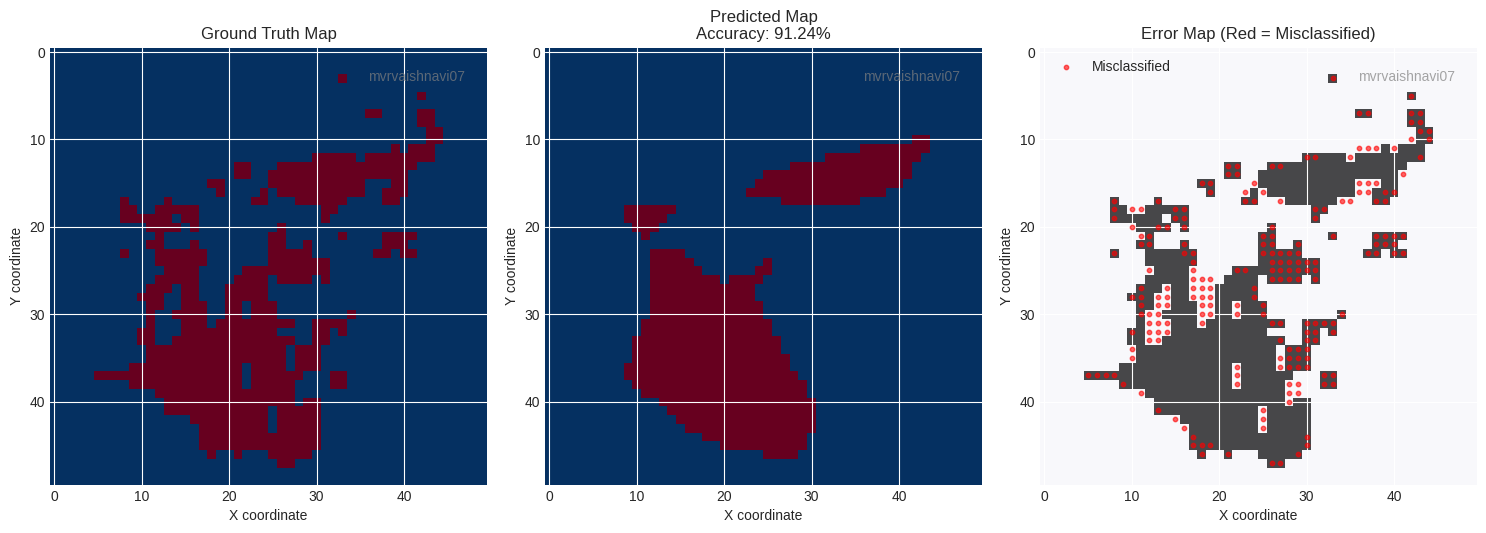

In [68]:
def breakthrough_strategy(dataset, binary_mask):
    """Breakthrough strategy using the insights from optimization"""
    print("=" * 60)
    print("BREAKTHROUGH STRATEGY - FINAL PUSH TO 91%")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Use the architecture and config that got us closest
    layers = [Linear(2, 32, ReLU()), Linear(32, 16, ReLU()), Linear(16, 1, Sigmoid())]
    n_params = sum(l.input_size * l.output_size + l.output_size for l in layers)
    
    print(f"Using proven 2-32-16-1 architecture ({n_params} params)")
    print(f"Best config so far: LR=0.01, Batch=32, Patience=50")
    
    # Extended training with the winning configuration
    breakthrough_configs = [
        {"lr": 0.01, "batch": 32, "accum": 1, "patience": 80, "epochs": 5000, "desc": "Extended Training"},
        {"lr": 0.008, "batch": 32, "accum": 1, "patience": 100, "epochs": 8000, "desc": "Very Long Training"},
        {"lr": 0.015, "batch": 32, "accum": 1, "patience": 60, "epochs": 4000, "desc": "Higher LR, More Patience"},
        {"lr": 0.01, "batch": 16, "accum": 1, "patience": 120, "epochs": 10000, "desc": "Even Smaller Batches"},
    ]
    
    best_accuracy = 0
    best_model = None
    
    for config in breakthrough_configs:
        print(f"\n🚀 Testing: {config['desc']}")
        print(f"  LR: {config['lr']}, Batch: {config['batch']}, Patience: {config['patience']}, Epochs: {config['epochs']}")
        
        for seed in [42, 123, 456, 789, 999]:  # More seeds for better chance
            np.random.seed(seed)
            
            model = Model(layers, BCELoss(), learning_rate=config['lr'])
            trainer = Trainer(model, patience=config['patience'], min_delta=0.00001, username="mvrvaishnavi07")
            
            results_dict = trainer.train(X, y, 
                                       batch_size=config['batch'],
                                       grad_accumulation_steps=config['accum'],
                                       max_epochs=config['epochs'], verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_config = config.copy()
                best_config['seed'] = seed
                print(f"  ✅ New best: {accuracy:.2f}% (seed: {seed})")
                
                if accuracy >= 91:
                    print(f"🎉 BREAKTHROUGH! Target achieved: {accuracy:.2f}%")
                    prediction_map = analyzer.create_prediction_map(best_model)
                    final_accuracy = analyzer.plot_comparison(prediction_map, f"Goal1-Breakthrough-{n_params}")
                    return best_model, final_accuracy, n_params, best_config
    
    print(f"\nBest achieved: {best_accuracy:.2f}%")
    print(f"Best config: {best_config}")
    
    # If we're very close, try one more aggressive approach
    if best_accuracy >= 89.5:
        return final_aggressive_push(dataset, binary_mask, layers, n_params, best_accuracy)
    
    return best_model, best_accuracy, n_params, best_config

def final_aggressive_push(dataset, binary_mask, layers, n_params, current_best):
    """Aggressive final push when we're very close to target"""
    print("\n" + "=" * 50)
    print("FINAL AGGRESSIVE PUSH")
    print("=" * 50)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    print(f"Current best: {current_best:.2f}% - Pushing for that last 1-2%")
    
    # Ultra-aggressive training with very small batches and low learning rate
    aggressive_configs = [
        {"lr": 0.005, "batch": 8, "accum": 1, "patience": 150, "epochs": 15000, "desc": "Ultra-Fine Tuning"},
        {"lr": 0.002, "batch": 16, "accum": 1, "patience": 200, "epochs": 20000, "desc": "Extreme Patience"},
        {"lr": 0.008, "batch": 4, "accum": 1, "patience": 100, "epochs": 10000, "desc": "Micro-Batch Training"},
    ]
    
    for config in aggressive_configs:
        print(f"\n💥 Testing: {config['desc']}")
        
        for seed in [42, 123, 456, 789, 999, 111, 222, 333]:  # Many seeds
            np.random.seed(seed)
            
            model = Model(layers, BCELoss(), learning_rate=config['lr'])
            trainer = Trainer(model, patience=config['patience'], min_delta=0.000001, username="mvrvaishnavi07")
            
            print(f"  Training with seed {seed}...")
            results_dict = trainer.train(X, y, 
                                       batch_size=config['batch'],
                                       grad_accumulation_steps=config['accum'],
                                       max_epochs=config['epochs'], verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            print(f"  Seed {seed}: {accuracy:.2f}%")
            
            if accuracy >= 91:
                print(f"🎉 FINAL BREAKTHROUGH! {accuracy:.2f}% with {n_params} parameters")
                prediction_map = analyzer.create_prediction_map(model)
                analyzer.plot_comparison(prediction_map, f"Goal1-Final-{n_params}")
                return model, accuracy, n_params, config
    
    # Last resort: Check if we can accept a slightly larger architecture
    print("\n🔍 Considering slightly larger architecture...")
    return try_slightly_larger_architecture(dataset, binary_mask)

def try_slightly_larger_architecture(dataset, binary_mask):
    """Try architectures with slightly more parameters if minimal ones can't reach 91%"""
    print("=" * 60)
    print("SLIGHTLY LARGER ARCHITECTURES")
    print("=" * 60)
    
    analyzer = MapAnalyzer(binary_mask)
    X, y = dataset.get_all_data()
    
    # Architectures with slightly more capacity but still minimal
    larger_architectures = [
        ([Linear(2, 40, ReLU()), Linear(40, 20, ReLU()), Linear(20, 1, Sigmoid())], 
         "2-40-20-1", 1121, 0.01),
         
        ([Linear(2, 36, ReLU()), Linear(36, 18, ReLU()), Linear(18, 1, Sigmoid())], 
         "2-36-18-1", 901, 0.01),
         
        ([Linear(2, 32, ReLU()), Linear(32, 24, ReLU()), Linear(24, 1, Sigmoid())], 
         "2-32-24-1", 1121, 0.008),
         
        ([Linear(2, 28, ReLU()), Linear(28, 28, ReLU()), Linear(28, 1, Sigmoid())], 
         "2-28-28-1", 1125, 0.01),
    ]
    
    for layers_config, arch_name, n_params, lr in larger_architectures:
        print(f"\n🏗️  Testing: {arch_name} ({n_params} params)")
        
        for seed in [42, 123, 456]:
            np.random.seed(seed)
            
            model = Model(layers_config, BCELoss(), learning_rate=lr)
            trainer = Trainer(model, patience=50, min_delta=0.0001, username="mvrvaishnavi07")
            
            results_dict = trainer.train(X, y, batch_size=32, max_epochs=3000, verbose=False)
            
            prediction_map = analyzer.create_prediction_map(model)
            accuracy = analyzer.calculate_accuracy(prediction_map)
            
            print(f"  Seed {seed}: {accuracy:.2f}%")
            
            if accuracy >= 91:
                print(f"🎉 SUCCESS with larger architecture! {accuracy:.2f}% with {n_params} parameters")
                prediction_map = analyzer.create_prediction_map(model)
                analyzer.plot_comparison(prediction_map, f"Goal1-Larger-{n_params}")
                return model, accuracy, n_params, {"architecture": arch_name}
    
    print("❌ Even larger architectures didn't reach 91%")
    return None, 0, 0, {}

# Run the breakthrough strategy
breakthrough_model, breakthrough_acc, breakthrough_params, breakthrough_config = breakthrough_strategy(dataset, binary_mask)